In [281]:
# mypy: ignore-errors
import os
import sys
import matplotlib
import pandas as pd
import pdb
from IPython import get_ipython
from IPython.display import display

is_notebook = True if "script" not in os.getcwd() else False
recidiviz_data_path = "../../../../../../.." + ("/.." if not is_notebook else "")

sys.path.insert(0, os.path.relpath(recidiviz_data_path))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml
from recidiviz.utils.yaml_dict import YAMLDict

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [282]:
# Get the simulation tag from the model inputs config
yaml_file_path = ("../" if not is_notebook else "") + "tx_gun_minimums_v1.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

In [283]:
simulation_tag

'tx_gun_minimums_no_probation_v1'

In [284]:
if (is_notebook):
    get_ipython().run_line_magic('run', recidiviz_data_path + "/../recidiviz-research/utils/research_utils.py")

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 3600x2100 with 0 Axes>

# LOAD SIMULATION

In [285]:
policy_sim = SuperSimulationFactory.build_super_simulation(yaml_file_path)

Downloading: 100%|█████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1157.47rows/s]
Downloading: 0rows [00:00, ?rows/s]
Downloading: 100%|██████████████████████████████████████████████████████| 172/172 [00:00<00:00, 742.20rows/s]


In [286]:
alt_transitions = pd.read_csv(
    ("../" if not is_notebook else "") + "alternate_transitions_no_probation.csv"
)

In [287]:
## Policy functions
def switch_transitions(compartment):
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alt_transitions[
            alt_transitions.compartment == compartment
        ],
        retroactive=False,
    )


def realloc_probation_to_prison():
    return partial(
        ShellCompartment.reallocate_outflow,
        reallocation_fraction=1,
        outflow="probation",
        new_outflow="prison",
    )

In [288]:
# Simulate policy starting in July 2023
policy_ts = 6

In [291]:
policy_list_with_probation = [
    SparkPolicy(
        policy_fn=switch_transitions(compartment),
        spark_compartment=compartment,
        sub_population={"crime_type": "gun"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    )
    for compartment in ["prison", "probation"]
]

In [292]:
policy_list_no_probation = [
    SparkPolicy(
        policy_fn=switch_transitions(compartment),
        spark_compartment=compartment,
        sub_population={"crime_type": "gun"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    )
    for compartment in ["prison"]
] + [
    SparkPolicy(
        policy_fn=realloc_probation_to_prison(),
        spark_compartment="pretrial",
        sub_population={"crime_type": "gun"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    )
]

In [293]:
policy_list = (
    policy_list_no_probation
    if "no_probation" in simulation_tag
    else policy_list_with_probation
)

# SIMULATE SIMULATION

/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/TX/gun_mm/../../../../../../../recidiviz/calculator/modeling/population_projection/population_simulation/population_simulation_factory.py:168: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (simulation_group_name), _ in transitions_data.groupby(disaggregation_axes):


initialization time:  7.006608963012695


/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/TX/gun_mm/../../../../../../../recidiviz/calculator/modeling/population_projection/population_simulation/population_simulation_factory.py:168: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (simulation_group_name), _ in transitions_data.groupby(disaggregation_axes):


initialization time:  6.9593260288238525
simulation_time:  2.3805627822875977
simulation_time:  2.383485794067383
114733.78537406822


/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/TX/gun_mm/../../../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/simulator.py:314: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simulation_results = simulation_results.groupby(


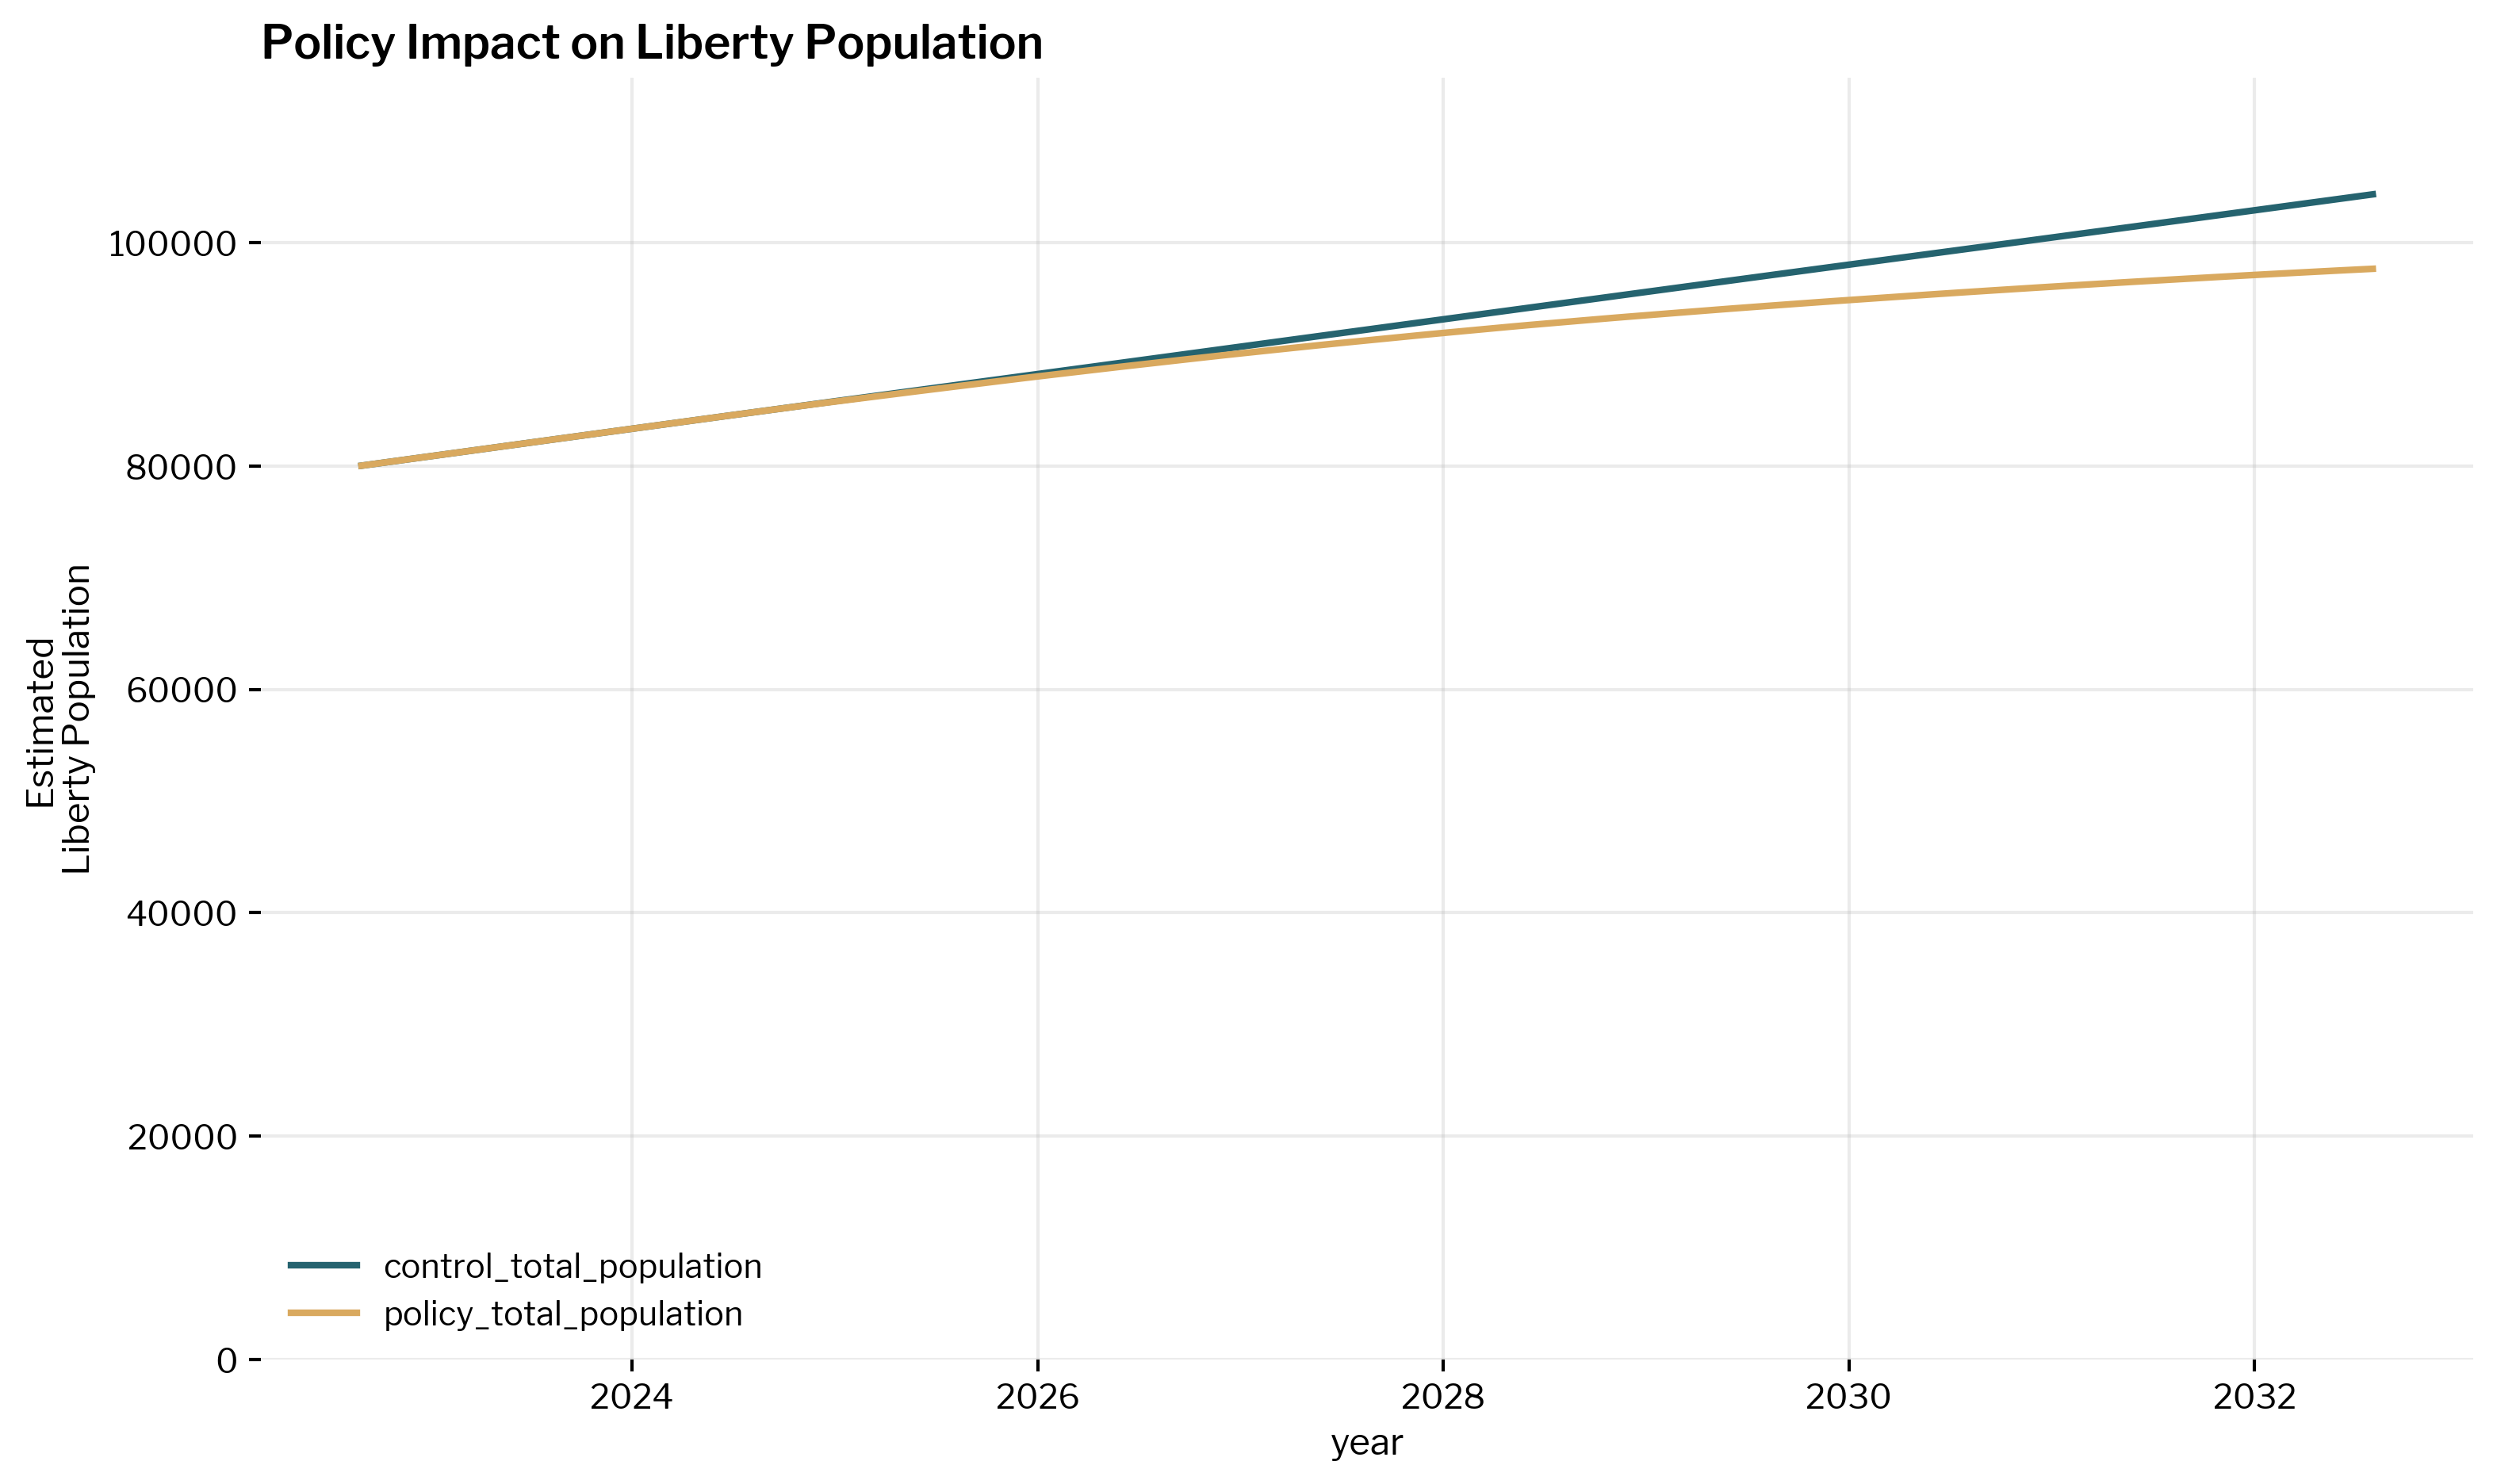

In [294]:
policy_results = policy_sim.simulate_policy(policy_list, "liberty")
policy_results["population_difference"] = (
    policy_results["policy_total_population"]
    - policy_results["control_total_population"]
)

In [300]:
upload = True
simulation_tag

'tx_gun_minimums_no_probation_v1'

In [301]:
if upload:
    results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


In [298]:
popagg = (
    policy_results.groupby(["year", "compartment"])
    .sum()
    .reset_index()
    .pivot(
        index="year",
        columns=["compartment"],
        values=["policy_total_population", "control_total_population"],
    )
)
popdiff = (
    popagg.loc[:, "policy_total_population"] - popagg.loc[:, "control_total_population"]
)
popdiff.loc[np.arange(2023, 2029, 0.5)]
# policy_results.reset_index().head()

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_99229/3608261659.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  policy_results.groupby(["year", "compartment"])


compartment,liberty,parole,prison,probation
year,,,,
2023.0,0.000000,0.000000,0.000000,0.000000
2023.5,0.000000,0.000000,59.000000,-59.000000
2024.0,-0.058905,-0.606423,413.606804,-412.941177
2024.5,-0.549333,-86.984780,854.063873,-766.529416
2025.0,-26.535600,-187.855136,1329.434080,-1115.042409
2025.5,-103.341526,-314.034392,1852.246379,-1434.868613
2026.0,-213.578142,-498.836888,2438.425950,-1726.008021
2026.5,-382.995649,-742.532528,3113.992729,-1988.460857
2027.0,-604.507405,-1005.932506,3832.671487,-2222.226934


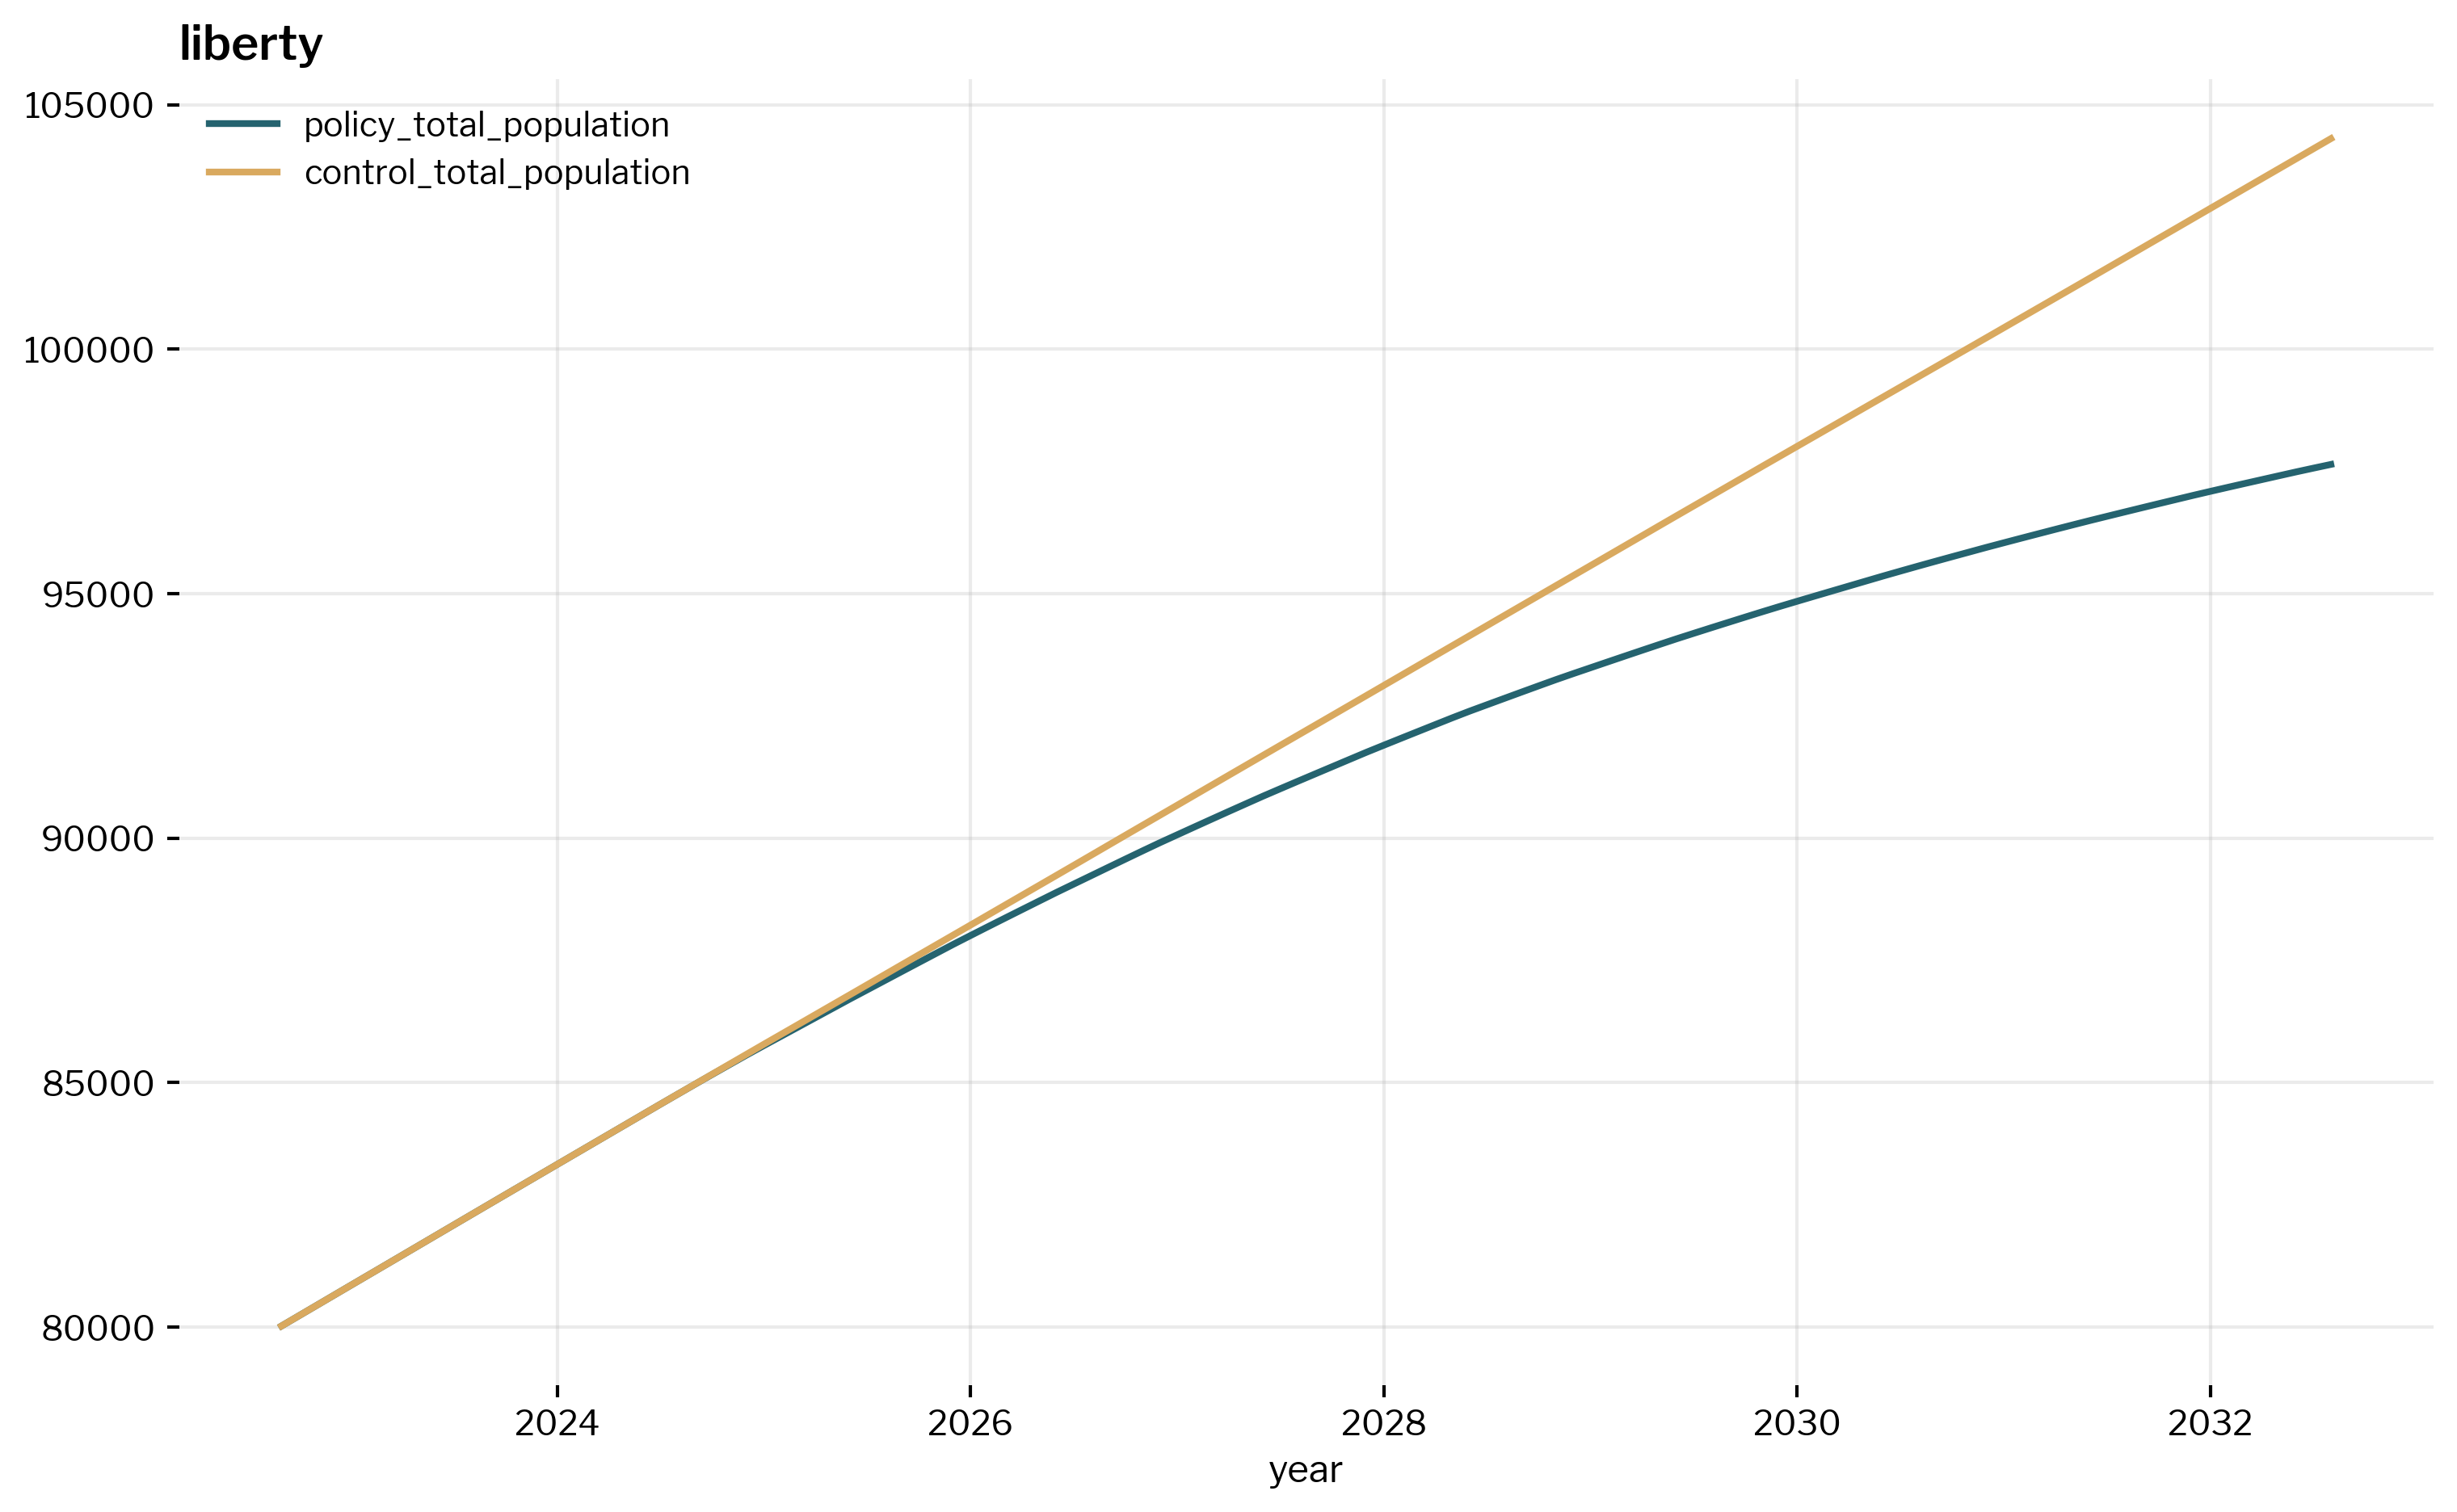

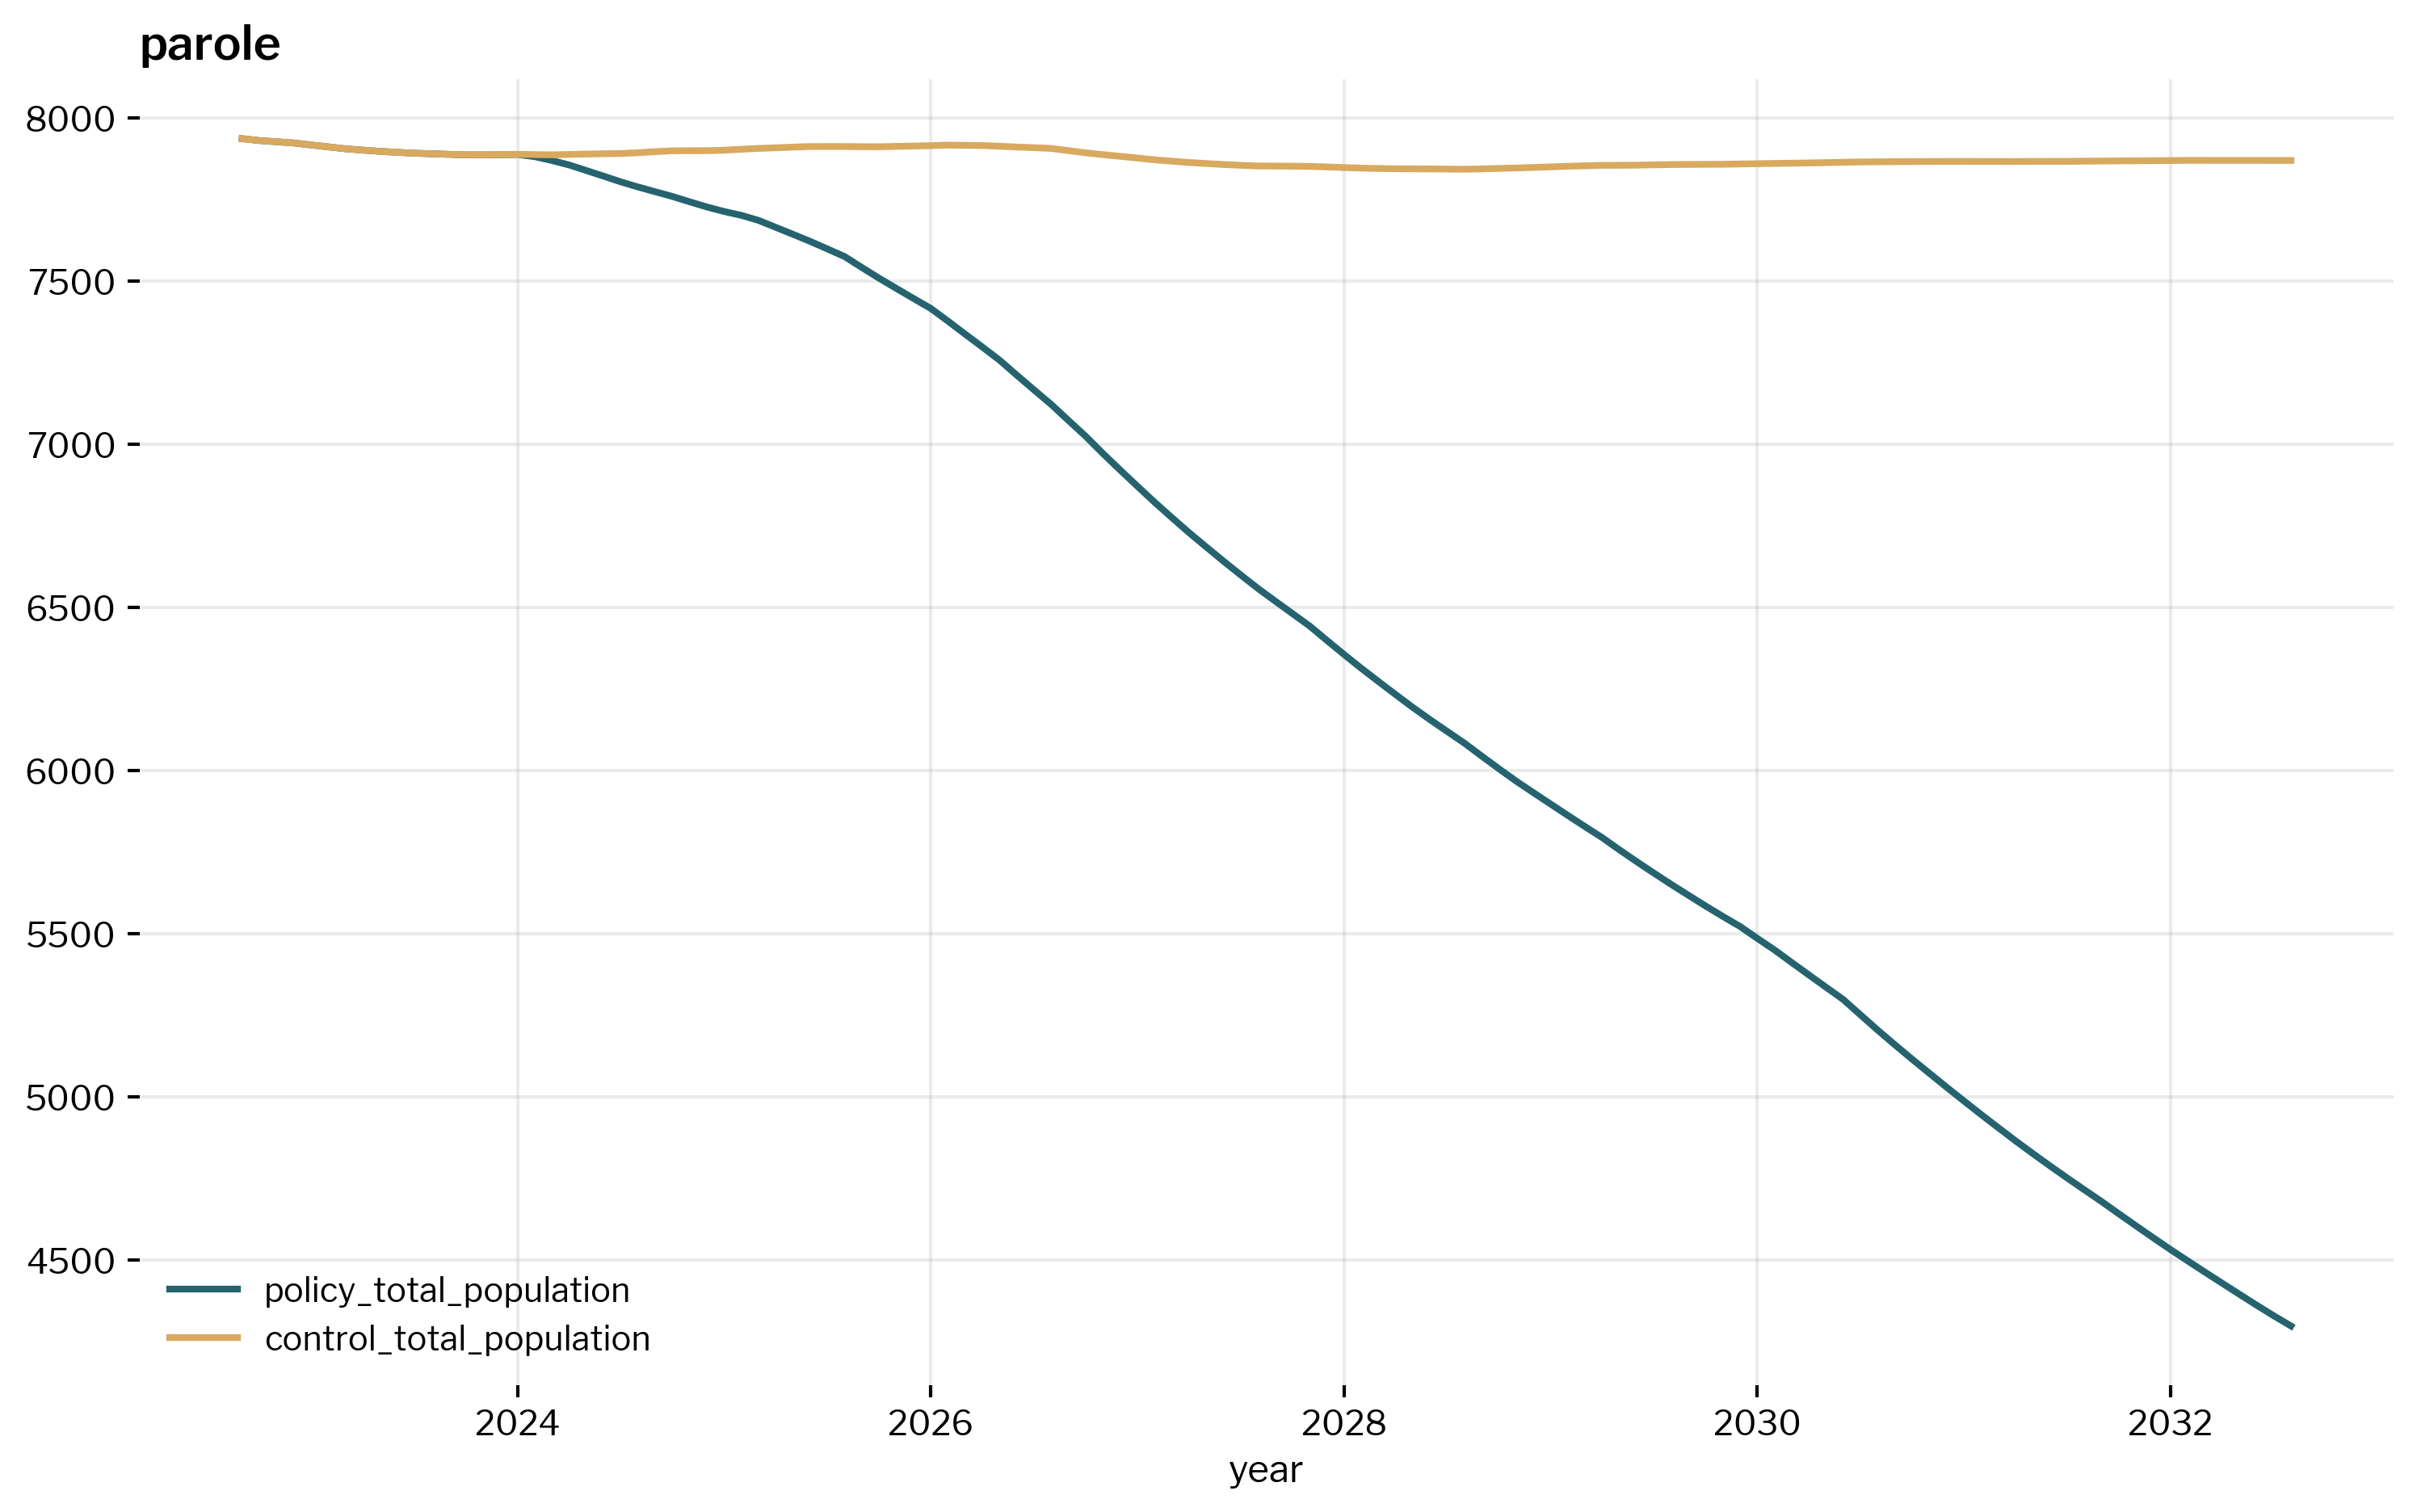

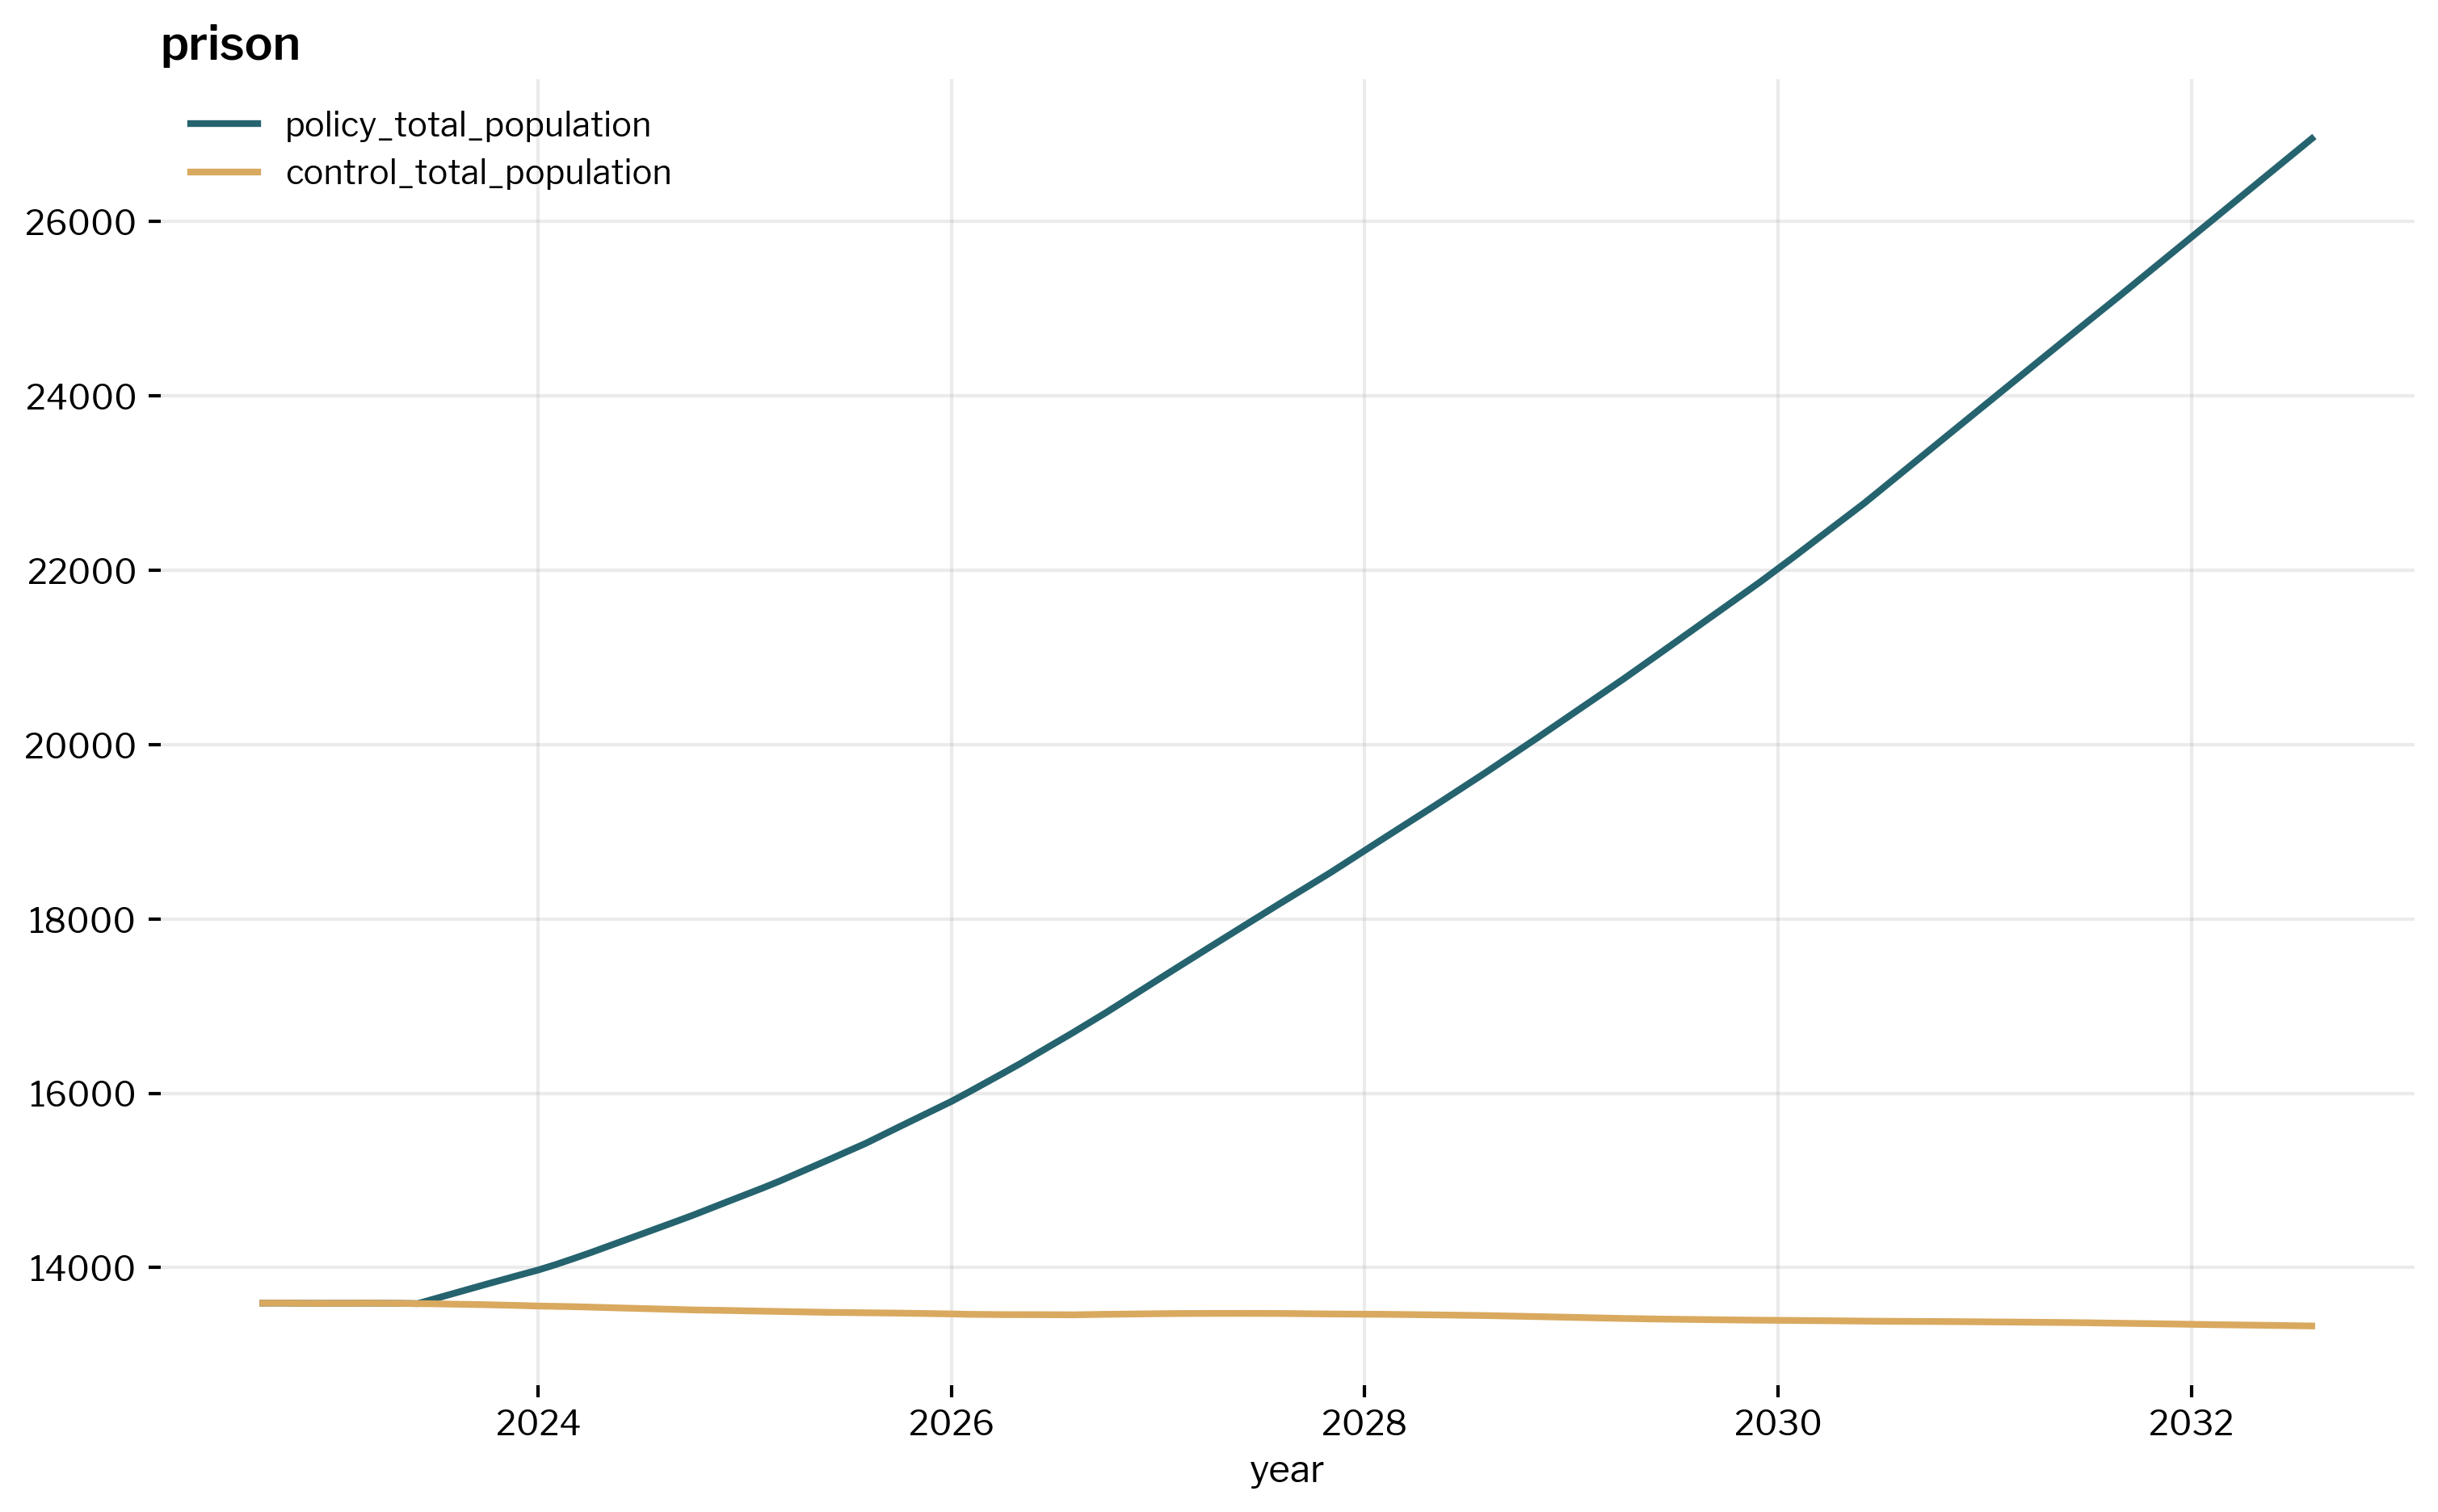

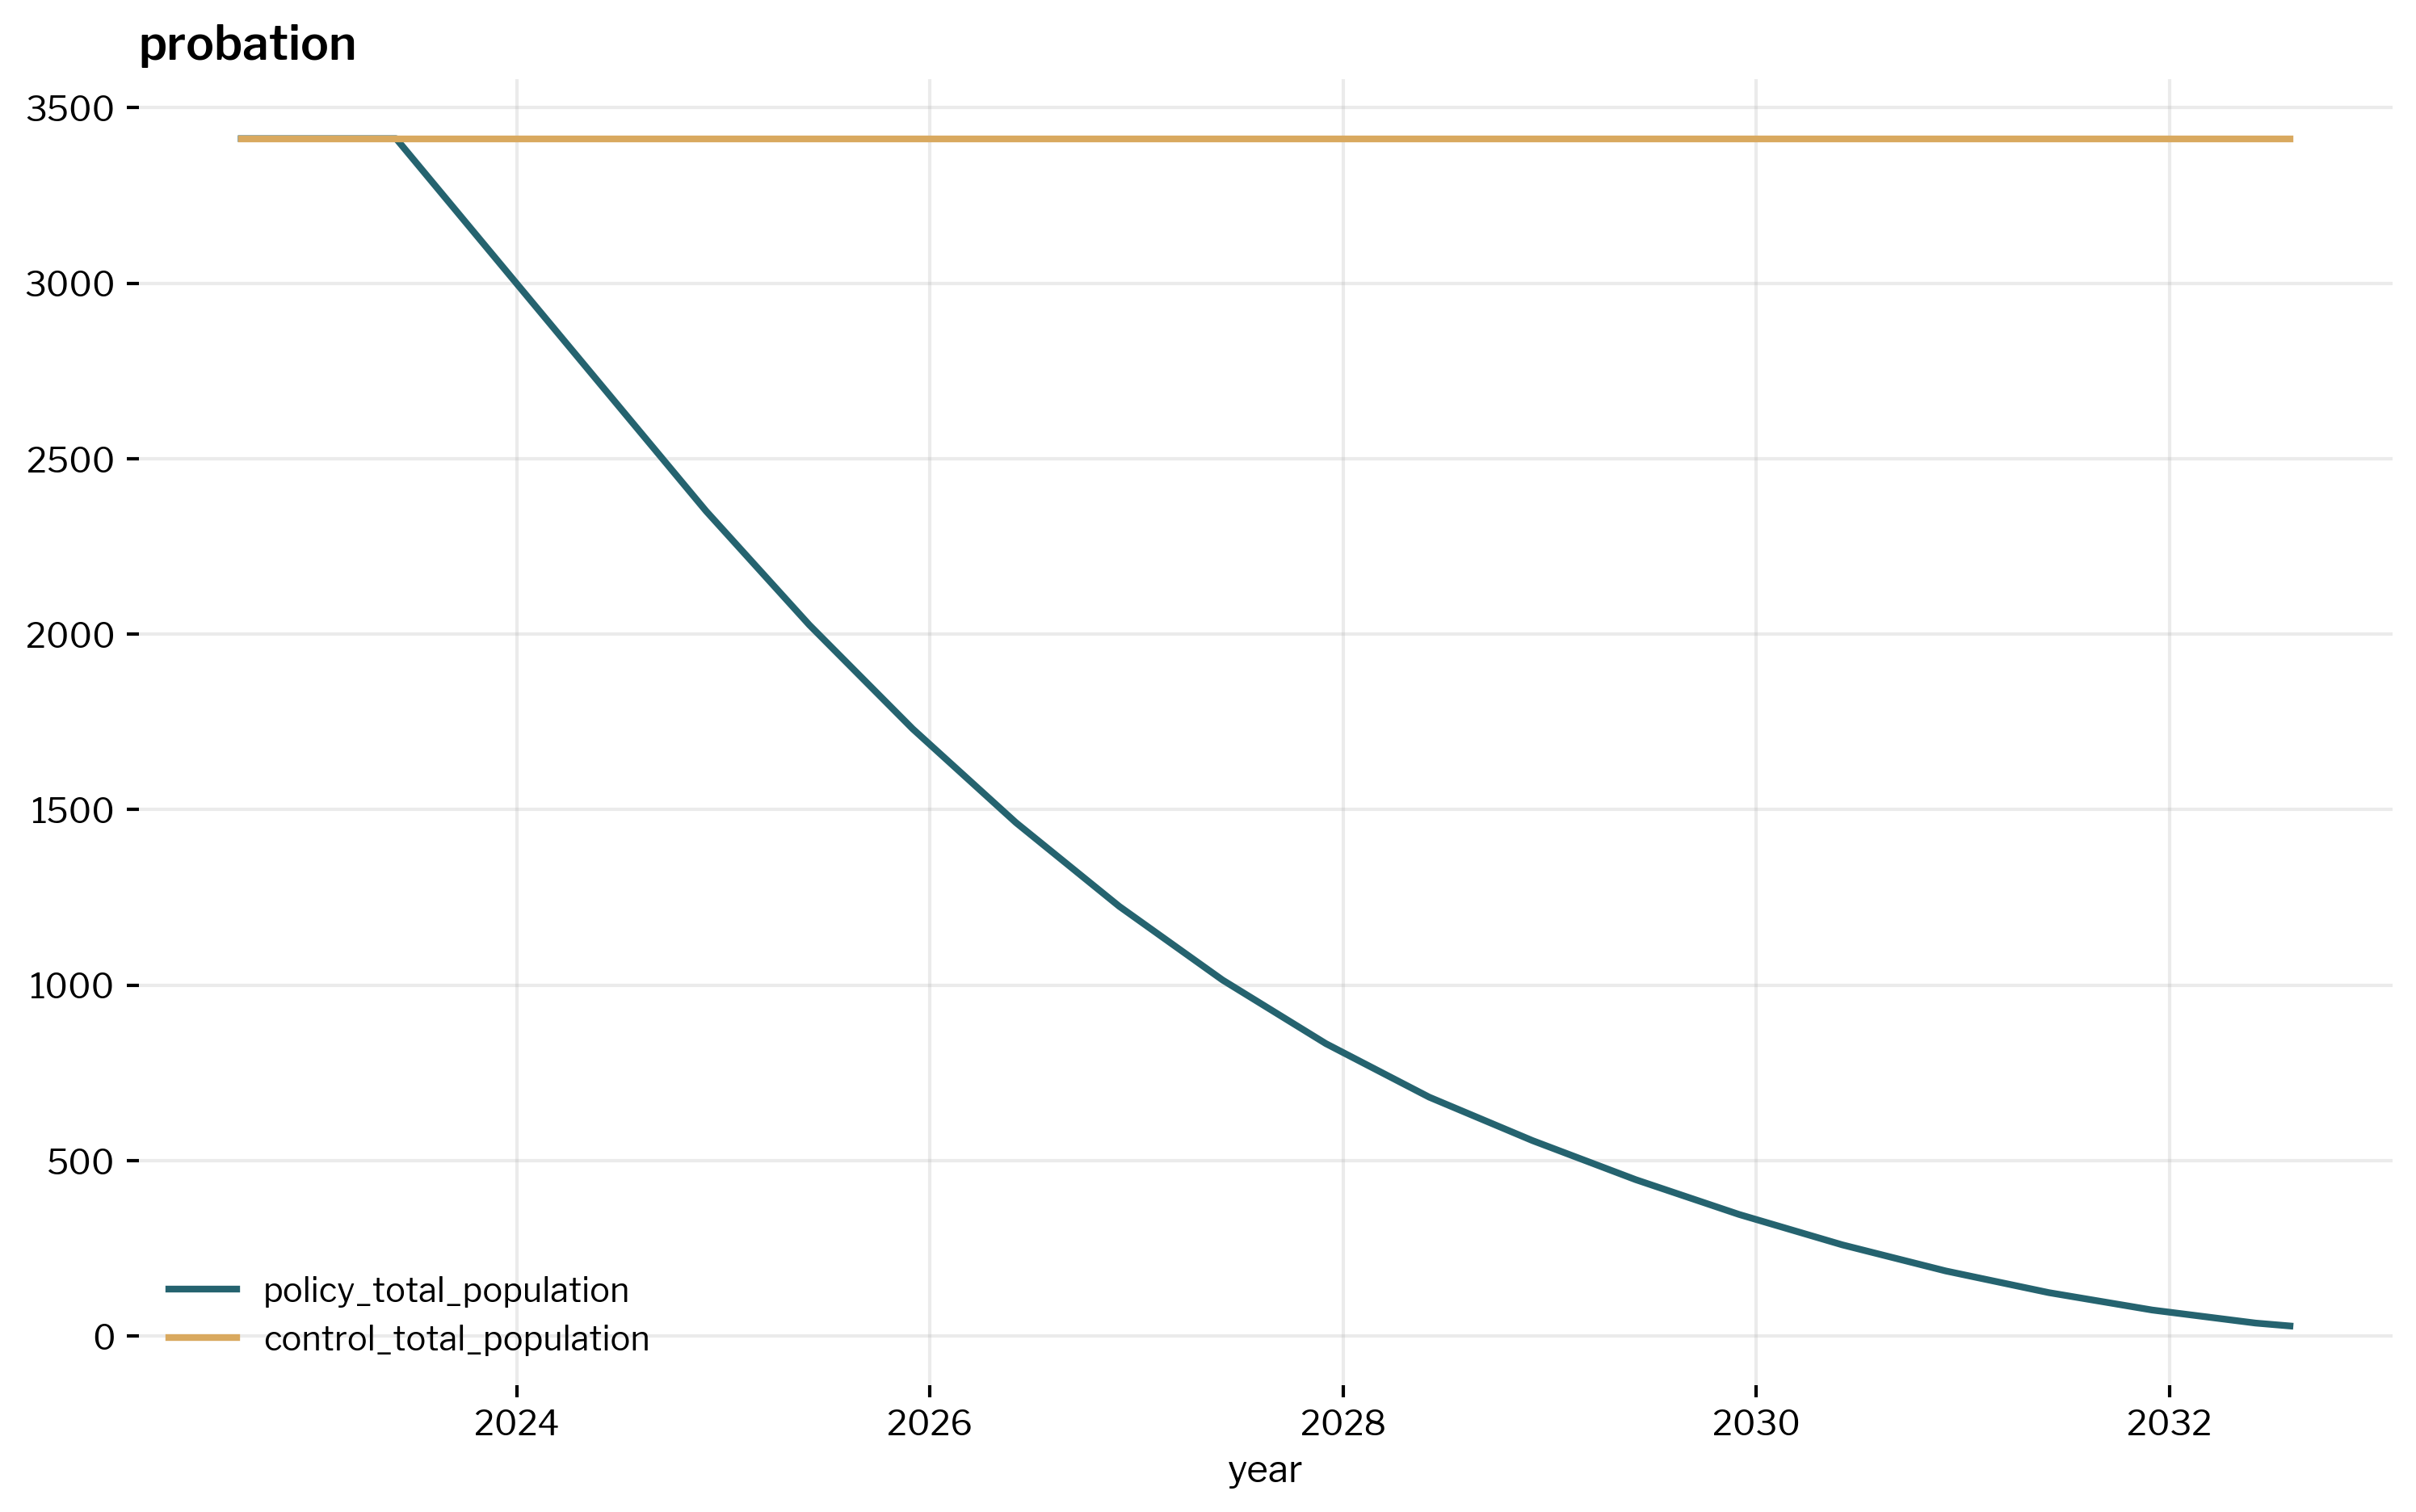

In [299]:
for comp in popagg.columns.get_level_values(1).unique():
    popagg.xs(comp, level="compartment", axis=1).plot()
    plt.title(comp)

In [70]:
policy_results["compartment_grouped"] = policy_results.compartment.mask(
    policy_results.compartment.str.contains("prison"), "prison"
)

pop_results_grouped = (
    policy_results.reset_index().groupby(["year", "compartment_grouped"]).sum()
)
popagg = pop_results_grouped.reset_index().pivot(
    index="year",
    columns=["compartment_grouped"],
    values=["policy_total_population", "control_total_population"],
)

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_99229/2450009695.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  policy_results.reset_index().groupby(["year", "compartment_grouped"]).sum()


In [71]:
for x in popagg.columns.get_level_values(1).unique():
    display(x)

'liberty'

'parole'

'prison'

'probation'

In [ ]:
for comp in popagg.columns.get_level_values(1).unique():
    popagg.xs(comp, level="compartment_grouped", axis=1).plot()
    plt.title(comp)

In [73]:
# popagg[popagg.columns.get_level_values(1) == "liberty"]

In [74]:
policy_sim.simulator.pop_simulations

{'control': <recidiviz.calculator.modeling.population_projection.population_simulation.population_simulation.PopulationSimulation at 0x14b05da90>,
 'policy': <recidiviz.calculator.modeling.population_projection.population_simulation.population_simulation.PopulationSimulation at 0x14ad758e0>}

In [75]:
subsimd = {
    "control": policy_sim.simulator.pop_simulations["control"].sub_simulations,
    "policy": policy_sim.simulator.pop_simulations["policy"].sub_simulations,
}
policy_sim.simulator.pop_simulations["control"].sub_simulations

{'gun': <recidiviz.calculator.modeling.population_projection.sub_simulation.sub_simulation.SubSimulation at 0x14ad5ab80>}

In [76]:
t = (
    policy_sim.simulator.pop_simulations["control"]
    .sub_simulations["nonviolent"]
    .simulation_compartments["parole"]
)
compflows = pd.DataFrame(t.outflows.copy()).T
compflows.prison = compflows.prisonrev.combine_first(compflows.prison)
compflows.melt(
    value_vars=["liberty", "parole", "prison"], var_name="outflow_to", value_name="num"
)
# compflows.compartment.head()

KeyError: 'nonviolent'

In [ ]:
policy_sim.simulator.pop_simulations["policy"].sub_simulations,

In [ ]:
def get_outflows_results(sim):
    outflows = policy_sim.simulator.pop_simulations[sim].get_outflows().reset_index()
    #     outflows['outflow_to'] = outflows.outflow_to.mask(
    #         outflows.outflow_to.str.contains('prison'),
    #         'prison'
    #     )

    outflows = (
        outflows.groupby(["compartment", "outflow_to", "time_step"])[
            ["total_population"]
        ]
        .sum()
        .reset_index()
    )
    outflows["simulation"] = sim
    #     outflows['outflow_tuple'] = outflows.compartment_grouped +","+ outflows.outflow_to
    return outflows

In [ ]:
outflows_control = (
    policy_sim.simulator.pop_simulations["control"].get_outflows().reset_index()
)
outflows_policy = (
    policy_sim.simulator.pop_simulations["policy"].get_outflows().reset_index()
)

In [ ]:
outflows = pd.concat([get_outflows_results(sim) for sim in ["control", "policy"]])
outflows_pivoted = outflows.pivot(
    index="time_step",
    columns=["compartment", "simulation", "outflow_to"],
    values="total_population",
)

In [ ]:
prison_outflows = outflows_pivoted.xs("prison", level="compartment", axis=1).xs(
    "parole", level="outflow_to", axis=1
)
prison_outflows["year"] = np.floor(prison_outflows.index / 12)
prison_outflows.head()
prison_outflows.groupby("year").sum()

In [ ]:
# b = outflows.xs('parole', level="compartment_grouped", axis=1)
# b['control','prison_total'] = b['control','prison'] + b['control','prisonrev']
# b['control']

In [ ]:
outflows_pivoted.head()

In [ ]:
for comp in ["parole", "pretrial", "prison", "prisonrev"]:
    comp_outflows = (
        outflows_pivoted.xs(comp, level="compartment", axis=1).fillna(0).loc[-24:]
    )
    comp_outflows = comp_outflows.loc[(comp_outflows != 0).any(axis=1)]
    #     display(comp_outflows.head())
    #     if comp == "parole":
    #         comp_outflows["control", "prison_total"] = (
    #             comp_outflows["control", "prison"] + comp_outflows["control", "prisonrev"]
    #         )
    #         comp_outflows["policy", "prison_total"] = (
    #             comp_outflows["policy", "prison"] + comp_outflows["policy", "prisonrev"]
    #         )
    comp_outflows.plot()
    plt.title(comp)

In [ ]:
x = list(outflows_pivoted.columns.get_level_values(0).unique())
x.remove("liberty")
x

In [77]:
for compartment, grouped in outflows.groupby("compartment"):
    for outflow_to, grouped2 in grouped.groupby("outflow_to"):
        grouped2.pivot(
            index=["time_step"],
            columns=["simulation", "outflow_to"],
            values=["total_population"],
        ).plot()
        plt.title(f"{compartment} -> {outflow_to}")


#     display(grouped.head())
#     grouped[['time_step','total_population']].plot()
#     grouped.pivot(
#         index=['time_step'],
#         columns=['simulation','outflow_to'],
#         values=['total_population']
#     )

NameError: name 'outflows' is not defined

In [78]:
outflowslist = []
pop = []
for sim_name, sim in policy_sim.simulator.pop_simulations.items():
    for subsim_name, subsim in sim.sub_simulations.items():
        for comp, comp_results in subsim.simulation_compartments.items():
            #             display(f"{sim_name} {subsim_name} {comp} {comp_results.outflows.shape}")
            compflows = pd.DataFrame(comp_results.outflows.copy()).T
            #             compflows = pd.DataFrame(t.outflows.copy()).T
            #             compflows.prison = compflows.prisonrev.combine_first(compflows.prison)
            #             compflows.melt(value_vars=['liberty','parole','prison'],var_name='outflow_to',value_name='num')
            #             compflows.compartment
            compflows["sim"] = sim_name
            compflows["crime_type"] = subsim_name
            compflows["compartment"] = comp
            outflowslist.append(compflows)
display(len(outflowslist))
outflows = pd.concat(outflowslist)
outflows.prison = outflows.prisonrev.combine_first(outflows.prison)
outflows.head()

10

AttributeError: 'DataFrame' object has no attribute 'prisonrev'

In [74]:
outflows.reset_index().groupby(["index", "sim"]).sum().drop(
    columns="prisonrev"
).reset_index().pivot(index="index", columns="sim")

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_3588/2199113753.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  outflows.reset_index().groupby(["index", "sim"]).sum().drop(


liberty                     parole                 prison  \
sim          control         policy     control      policy    control   
index                                                                    
-301      293.000000     293.000000  278.000000  278.000000  81.000000   
-300      594.437929     594.437929  278.000000  278.000000  81.000000   
-299      898.464676     898.464676  278.000000  278.000000  81.000000   
-298     1205.545188    1205.545188  278.000000  278.000000  81.000000   
-297     1514.811740    1514.811740  278.000000  278.000000  81.000000   
...              ...            ...         ...         ...        ...   
 120   136879.946784  136471.495237   15.990283   65.921303   4.639304   
 121   137019.856904  136617.610266   15.801989   65.756868   4.642666   
 122   137161.349222  136765.428601   16.042270   66.021012   4.647603   
 123   137309.880498  136920.402442   17.771103   67.773705   4.655069   
 124        0.000000       0.000000    0.000000    0.000000   0.000000   

                  
sim       policy  
index             
-301   81.000000  
-300   81.000000  
-299   81.000000  
-298   81.000000  
-297   81.000000  
...          ...  
 120   18.143546  
 121   18.250159  
 122   18.307876  
 123   18.367418  
 124    0.000000  

[426 rows x 6 columns]

# outflow TARGET COMPARISON

In [75]:
desired_outflows = {
    "prison": {"liberty": 367, "parole": 47.4},
    "parole": {"liberty": 35.4, "prisonrev": 97.5},
}

'pretrial'

outflow_to,liberty_control,parole_control,prison_control,prisonrev_control
-24,0.0,0.0,104.0,0.0
-23,0.0,0.0,120.0,0.0
-22,0.0,0.0,158.0,0.0
-21,0.0,0.0,196.0,0.0
-20,0.0,0.0,184.0,0.0


outflow_to,liberty_policy,parole_policy,prison_policy,prisonrev_policy
-24,0.0,0.0,104.0,0.0
-23,0.0,0.0,120.0,0.0
-22,0.0,0.0,158.0,0.0
-21,0.0,0.0,196.0,0.0
-20,0.0,0.0,184.0,0.0


,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124
outflow_to,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
prison_control,104.0,120.0,158.0,196.0,184.0,161.0,103.0,177.0,120.0,193.0,199.0,137.0,155.0,173.0,172.0,213.0,220.0,190.0,111.0,232.0,187.0,169.0,223.0,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,...,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333
prison_policy,104.0,120.0,158.0,196.0,184.0,161.0,103.0,177.0,120.0,193.0,199.0,137.0,155.0,173.0,172.0,213.0,220.0,190.0,111.0,232.0,187.0,169.0,223.0,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,...,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333


'prison'

outflow_to,liberty_control,parole_control,prison_control,prisonrev_control
-24,335.0,88.0,0.0,0.0
-23,427.0,107.0,0.0,0.0
-22,323.0,56.0,0.0,0.0
-21,414.0,55.0,0.0,0.0
-20,360.0,48.0,0.0,0.0


outflow_to,liberty_policy,parole_policy,prison_policy,prisonrev_policy
-24,335.0,88.0,0.0,0.0
-23,427.0,107.0,0.0,0.0
-22,323.0,56.0,0.0,0.0
-21,414.0,55.0,0.0,0.0
-20,360.0,48.0,0.0,0.0


,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123
outflow_to,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
liberty_control,335.0,427.0,323.0,414.0,360.0,381.0,405.0,348.0,332.0,381.0,393.0,351.0,365.0,359.0,378.0,361.0,335.0,336.0,371.0,385.0,339.0,404.0,94.702215,96.478288,95.921521,95.162197,96.691448,101.988196,98.437598,94.878473,102.466800,99.589797,100.037067,99.454086,100.253523,101.366212,104.333279,101.419417,104.049138,103.622935,99.713448,98.974006,104.303787,100.735789,102.140106,102.107790,100.826779,103.911907,102.436542,97.961162,...,119.764401,119.352795,115.596879,114.752623,119.510345,116.121592,117.347100,117.151885,115.913133,118.744927,117.221872,112.781635,110.498305,114.061239,115.866856,114.717342,116.228036,116.825922,118.130142,116.524839,115.900664,116.414377,117.736893,120.545388,123.416952,122.761615,121.273654,117.076306,121.976256,118.221777,123.328685,123.805608,119.689643,120.483076,124.965854,126.484194,126.806610,131.873181,128.821152,117.653100,133.297061,129.506667,129.171357,133.035508,125.913070,127.617067,126.330413,124.812794,126.427632,133.222684
parole_control,88.0,107.0,56.0,55.0,48.0,33.0,49.0,33.0,35.0,50.0,33.0,54.0,36.0,47.0,35.0,39.0,31.0,42.0,49.0,29.0,37.0,36.0,11.765916,11.765479,11.606596,11.509202,11.859788,12.217441,11.952647,11.875523,11.964555,11.727692,12.126940,12.544542,12.239942,12.903560,12.893290,11.840012,13.241327,12.860288,12.490954,12.516583,12.608965,12.759893,12.513745,12.336466,12.694031,13.463258,13.010742,12.298664,...,15.074765,14.611647,14.423910,14.903146,14.674052,14.889844,15.108657,15.331508,15.344457,14.847731,15.575241,15.192454,15.120627,15.751666,15.352964,15.466324,15.574913,15.219591,15.541923,15.490327,15.226094,14.968837,16.065117,15.505846,15.056027,16.023272,15.531439,15.557252,15.481590,15.549136,15.645431,15.907050,15.613100,15.858933,16.657474,16.654002,16.022125,17.571580,16.929413,15.595913,17.408456,17.011503,17.476559,17.361066,15.826687,15.964176,15.990283,15.801989,16.042270,17.771103
liberty_policy,335.0,427.0,323.0,414.0,360.0,381.0,405.0,348.0,332.0,381.0,393.0,351.0,365.0,359.0,378.0,361.0,335.0,336.0,371.0,385.0,339.0,404.0,94.702215,96.478288,95.921521,95.162197,96.691448,101.988196,98.437598,94.878473,101.954921,98.566022,98.501402,97.406531,97.694067,98.294854,100.750015,97.324261,99.442087,98.503989,94.082621,92.831294,97.649186,93.569287,94.461700,93.917496,92.124581,94.697812,92.710560,87.723298,...,91.863642,91.351011,87.494067,86.548792,91.205485,87.715712,88.840201,88.543962,87.204179,89.934949,88.310868,83.769604,81.385250,84.847156,86.551753,85.301214,86.710886,87.207749,88.410947,86.704621,85.979427,86.392115,87.613599,90.321071,93.091604,92.335246,90.746255,86.447886,91.246805,87.391301,92.397185,92.773084,88.556095,89.248500,93.630250,95.047566,95.268962,100.234504,97.081453,85.812371,101.355304,97.463884,97.027545,100.790678,93.567218,95.170184,93.782508,92.163868,93.677684,100.371715
parole_policy,88.0,107.0,56.0,55.0,48.0,33.0,49.0,33.0,35.0,50.0,33.0,54.0,36.0,47.0,35.0,39.0,31.0,42.0,49.0,29.0,37.0,36.0,11.765916,11.765479,11.606596,11.509202,11.859788,12.217441,11.952647,11.875523,13.487427,14.095189,15.339058,16.601281,17.486835,18.995087,19.829437,19.453700,21.449008,21.661971,22.232160,22.851790,23.538161,24.283090,24.630935,25.047654,26.344737,27.707963,27.849437,29.429191,...,50.872175,50.534064,50.471331,51.075577,51.039679,51.380481,51.724300,52.072154,52.210108,51.838391,52.759099,58.631354,58.670101,59.411715,59.123588,59.347522,59.634873,59.390128,59.823037,59.882017,59.728357,59.649868,60.856722,60.408031,60.068786,61.146610,60.765347,60.969923,61.004833,61.182952

'parole'

outflow_to,liberty_control,parole_control,prison_control,prisonrev_control
-24,0.0,0.0,0.0,121.0
-23,0.0,0.0,0.0,147.0
-22,0.0,0.0,0.0,118.0
-21,0.0,0.0,0.0,151.0
-20,0.0,0.0,0.0,141.0


outflow_to,liberty_policy,parole_policy,prison_policy,prisonrev_policy
-24,0.0,0.0,0.0,121.0
-23,0.0,0.0,0.0,147.0
-22,0.0,0.0,0.0,118.0
-21,0.0,0.0,0.0,151.0
-20,0.0,0.0,0.0,141.0


,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123
outflow_to,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
liberty_control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.234190,172.602552,190.850595,162.235413,205.248885,159.658509,152.445883,150.854952,186.621728,165.431891,130.509867,111.399948,107.902702,127.340422,114.269683,127.360416,110.319652,101.470315,103.488925,123.962660,96.733450,92.206423,82.382001,92.200935,83.325797,80.448876,71.420217,82.289535,...,20.646744,19.147602,19.333775,22.448958,18.248691,17.025370,15.111301,17.052039,14.990709,15.465955,14.107291,15.830761,14.108257,12.110744,11.819835,13.059918,14.740829,15.245174,14.316483,15.469079,12.836074,12.435236,13.735380,14.439560,12.350148,12.291592,11.938119,11.309288,12.009350,11.303729,11.321561,12.104346,11.339521,12.017913,11.576687,11.885529,11.491686,11.658708,11.437163,11.729196,12.187329,11.370356,11.633402,11.804179,10.934463,10.770318,10.894241,10.735562,10.690665,10.921100
prison_control,121.0,147.0,118.0,151.0,141.0,123.0,120.0,93.0,118.0,82.0,115.0,123.0,114.0,126.0,105.0,116.0,114.0,115.0,123.0,94.0,102.0,76.0,27.923699,27.195413,25.585924,24.412272,22.567570,21.293971,20.766384,20.382357,19.560584,18.142128,16.532332,15.188047,13.424586,12.576625,11.850606,10.936689,9.810931,9.287232,8.776185,8.349813,8.093796,7.673221,7.428114,7.164481,6.751885,6.522197,6.094772,5.846866,...,4.115907,4.122007,4.127136,4.132220,4.140790,4.147067,4.155754,4.168294,4.179052,4.197894,4.211723,4.222776,4.235642,4.245125,4.259467,4.269611,4.283822,4.295085,4.305929,4.317000,4.323549,4.328306,4.332154,4.343679,4.357127,4.361101,4.376900,4.384214,4.389504,4.399475,4.411649,4.425026,4.438459,4.445643,4.455166,4.472146,4.493847,4.501521,4.525496,4.545790,4.551402,4.573550,4.590736,4.609916,4.626355,4.630261,4.639304,4.642666,4.647603,4.655069
liberty_policy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.234190,172.602552,190.850595,162.235413,205.248885,159.658509,152.445883,150.854952,186.621728,165.510201,130.671574,111.663959,108.278584,127.851918,114.926490,128.172542,111.288949,102.648039,104.852106,125.524023,98.492230,94.170723,84.543938,94.558839,85.879803,83.209011,74.439697,85.549258,...,36.377520,35.088010,35.520765,38.846493,34.851446,33.838964,32.131453,34.274385,32.454004,33.388123,32.229335,34.430294,33.240664,31.592375,31.622584,33.118691,35.056047,35.819391,35.288006,36.705505,34.558333,34.356751,35.984679,36.875223,34.964942,35.107103,34.934098,34.487968,35.372257,35.093028,35.281507,36.530607,35.893580,36.708638,36.554671,37.074735,36.897498,37.246010,37.557822,38.045335,38.669158,38.027558,38.962988,39.262020,38.503803,38.471966,38.706114,38.675941,38.742410,39.086354
prison_policy,121.0,147.0,118.0,151.0,141.0,123.0,120.0,93.0,118.0,82.0,115.0,123.0,114.0,126.0,105.0,116.0,114.0,115.0,123.0,94.0,102.0,76.0,27.923699,27.195413,25.585924,24.412272,22.567570,21.293971,20.766384,20.382357,19.560584,18.154464,16.563844,15.245577,13.514976,12.709514,12.032837,11.175103,10.111015,9.653799,9.214046,8.866577,8.694276,8.362227,8.210458,8.044974,7.735338,7.616221,7.304177,7.176465,...,12.545192,12.671222,12.793709,12.914971,13.038542,13.159193,13.281076,13.404239,13.510747,13.624679,13.732937,13.838312,13.994494,14.145122,14.299833,14.449567,14.602593,14.752446,14.901104,15.018413,15.131266,15.242390,15.353222,15.471795,15.591802,15.702400,15.824887,15.938954,16.032345,16.130300,16.229789,16.330364,16.430535,16.523997,16.648693,16.780027,16.914710,17.034546,17.169865,17.300877,17.416386,17.547062,17.671954,17.798022,17.920530,18.029879

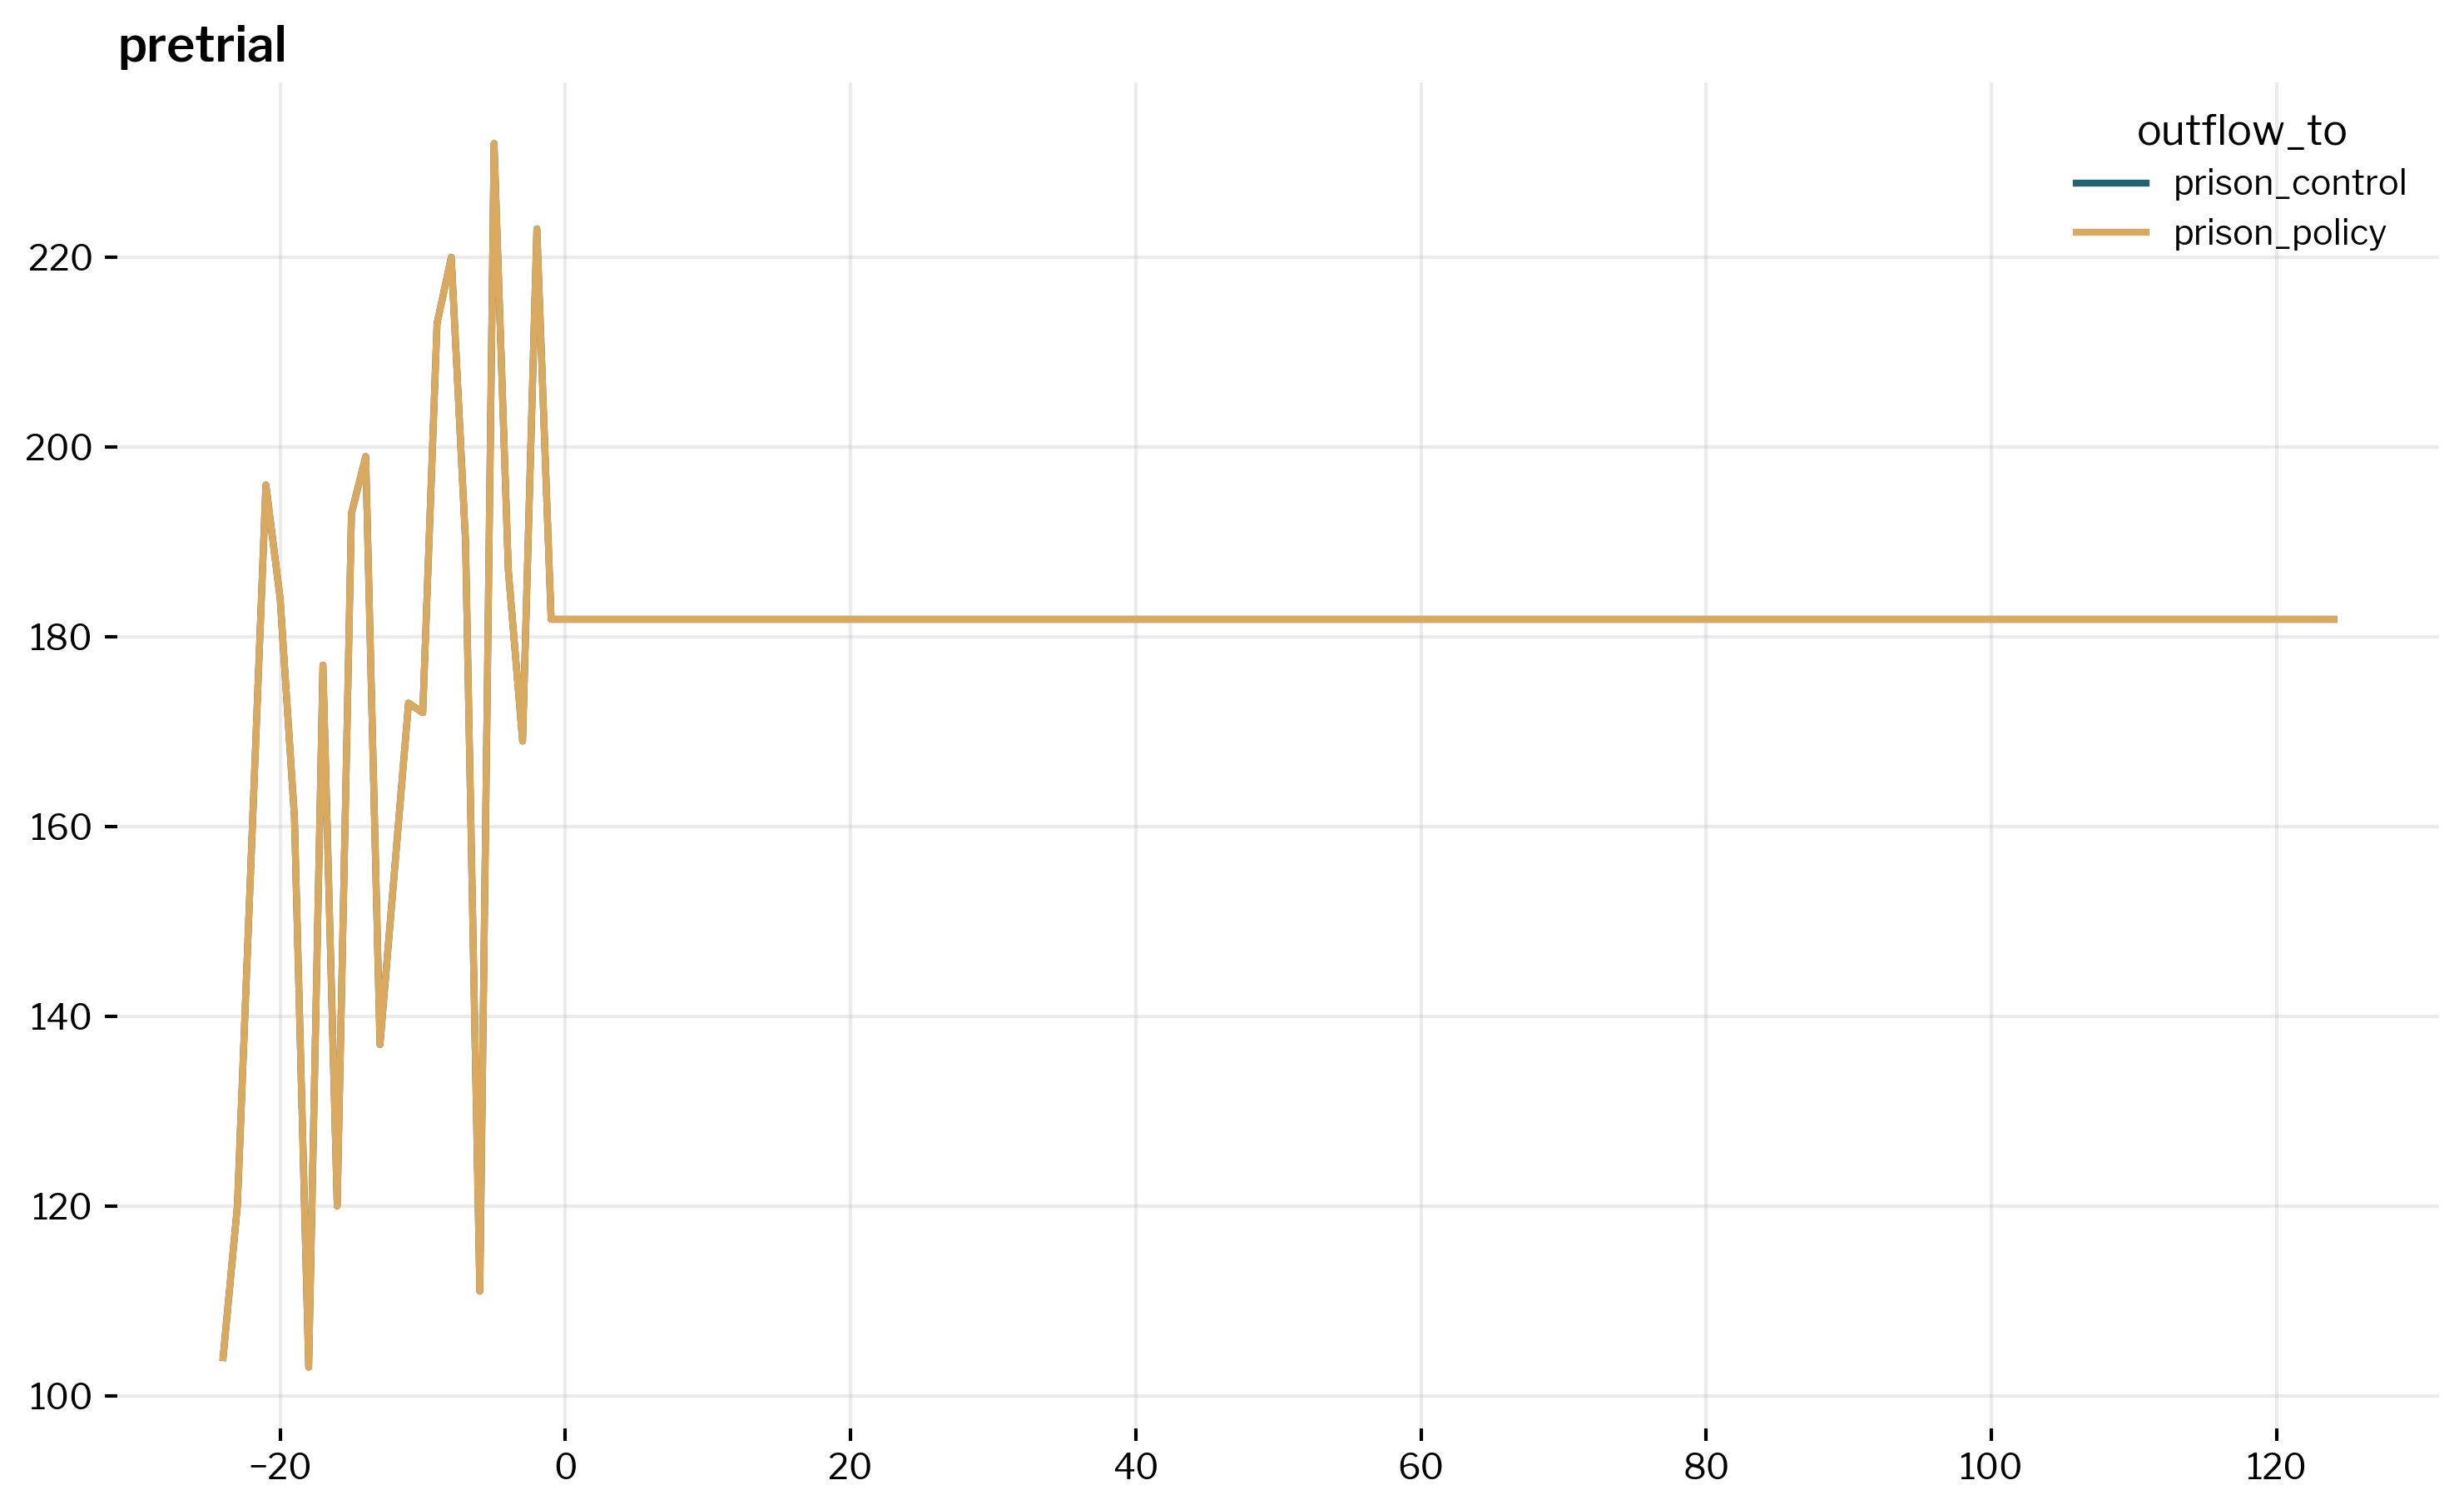

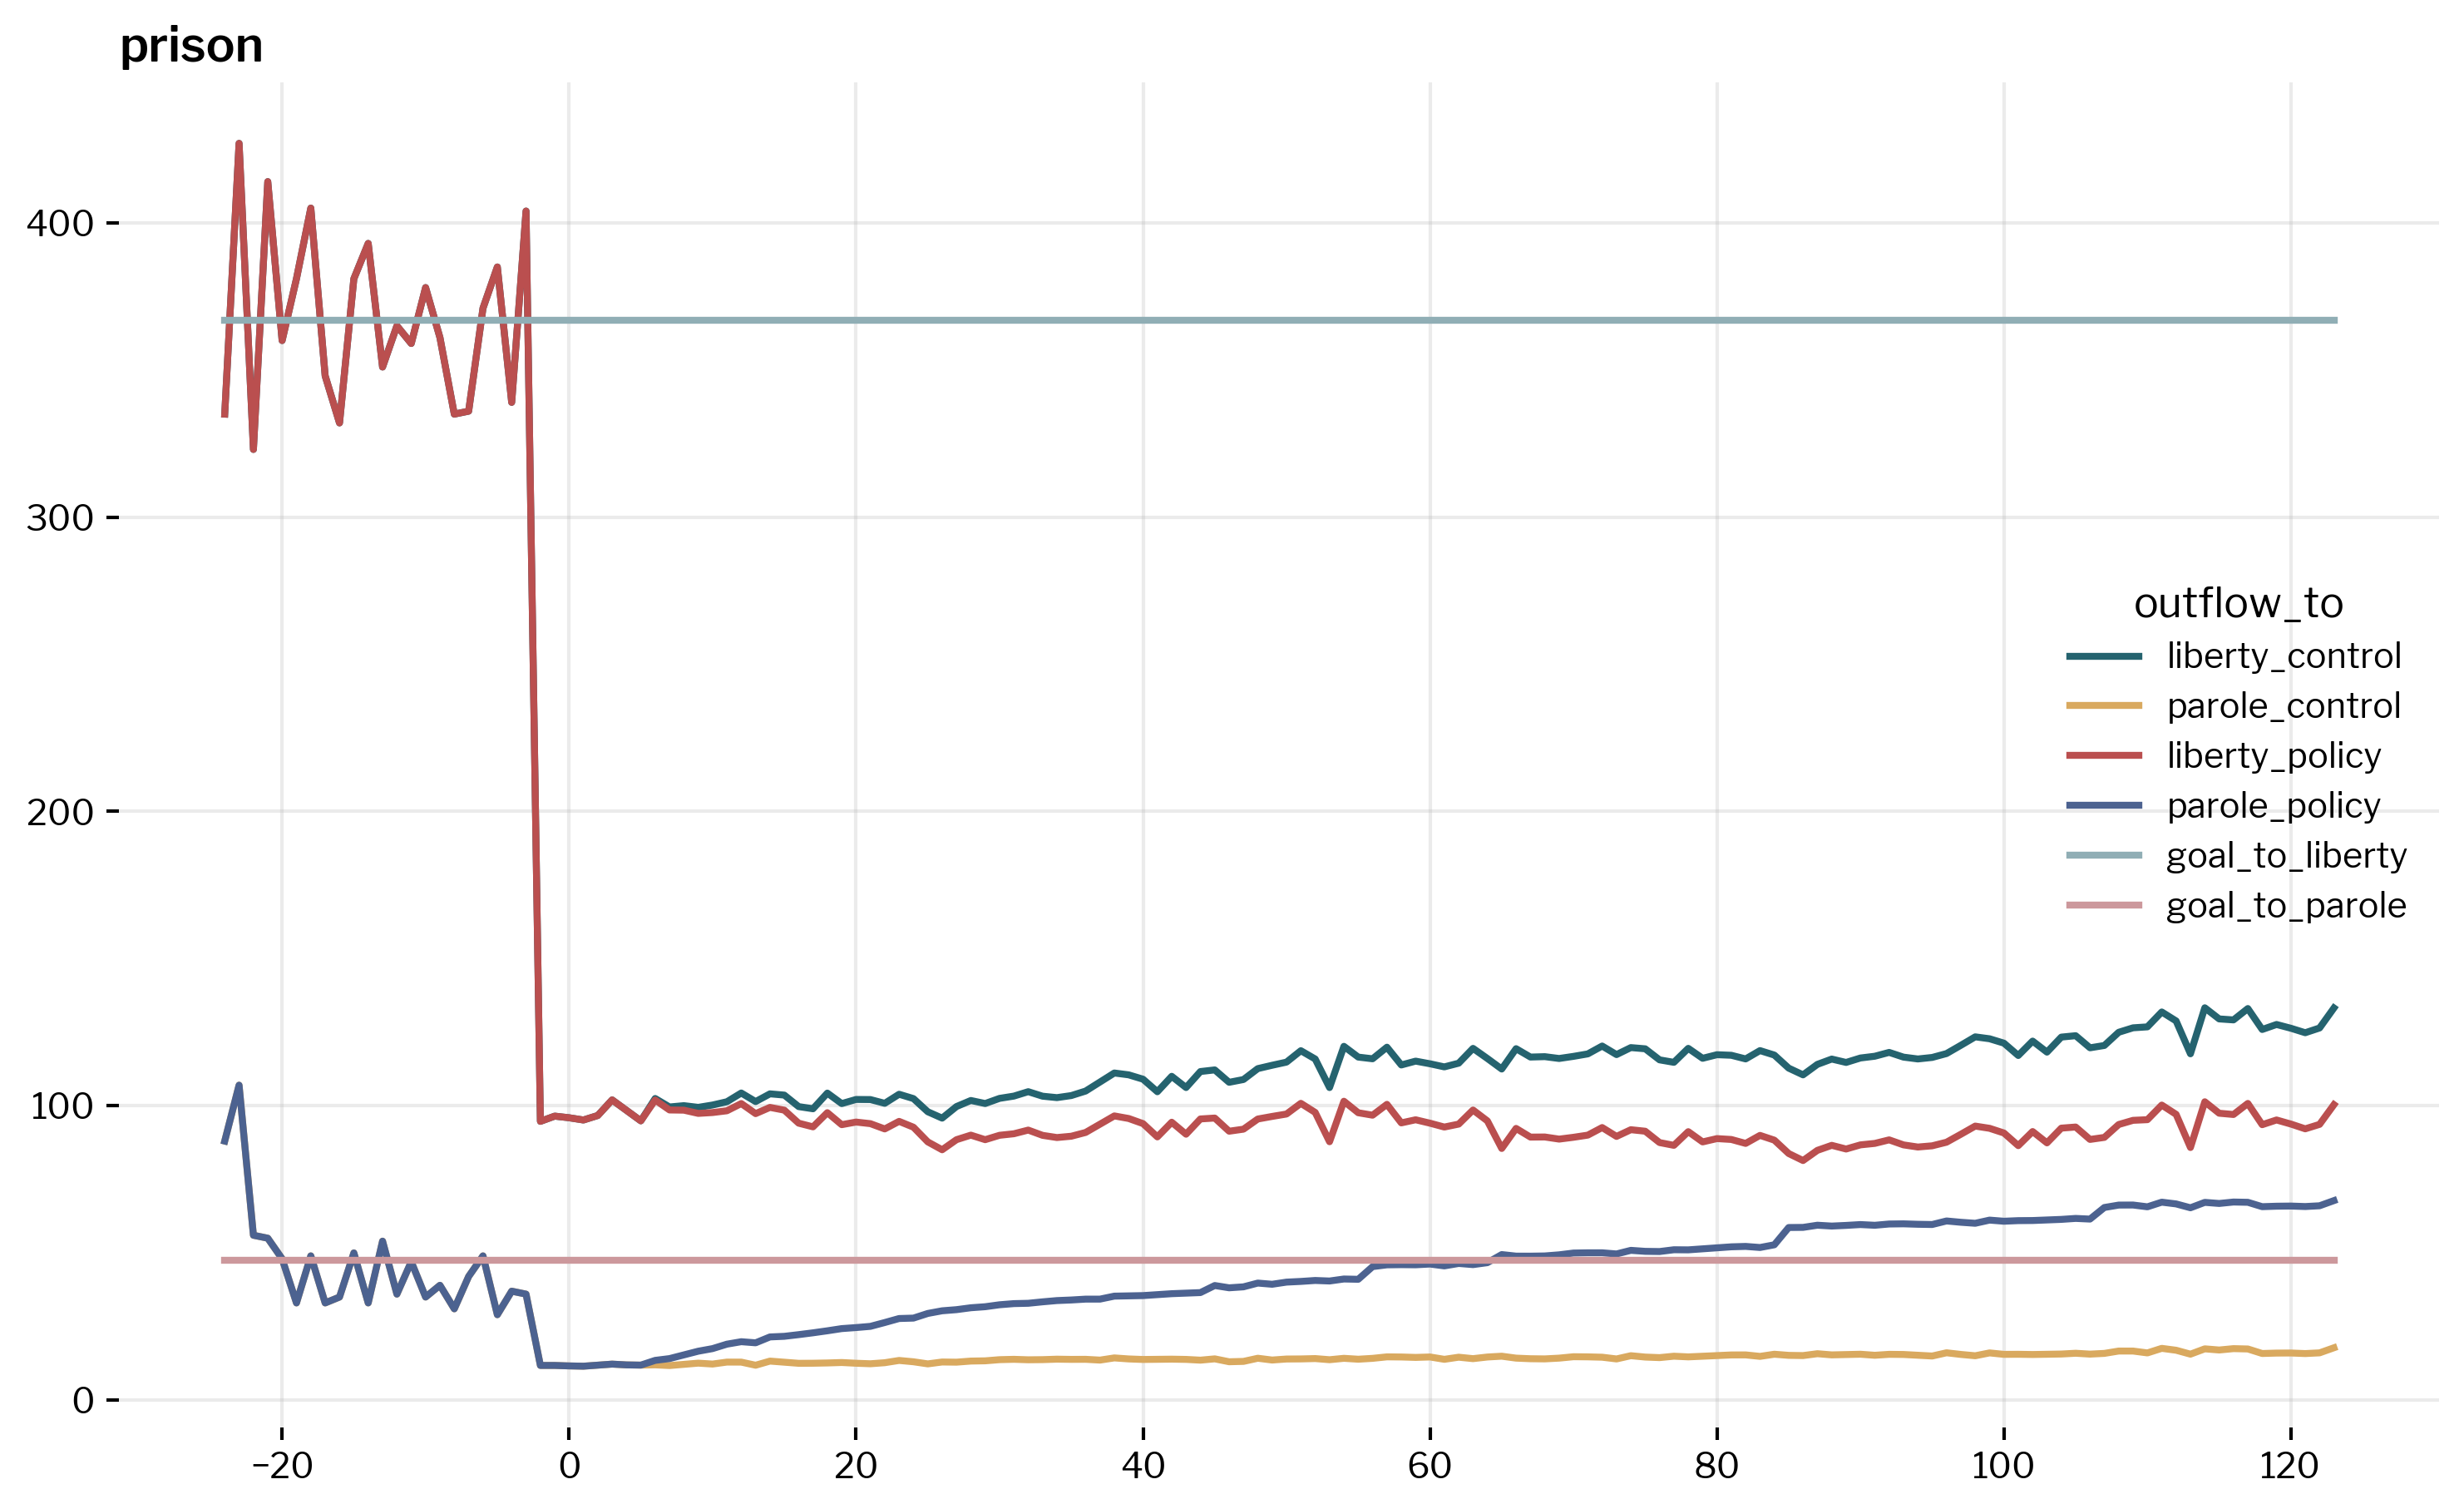

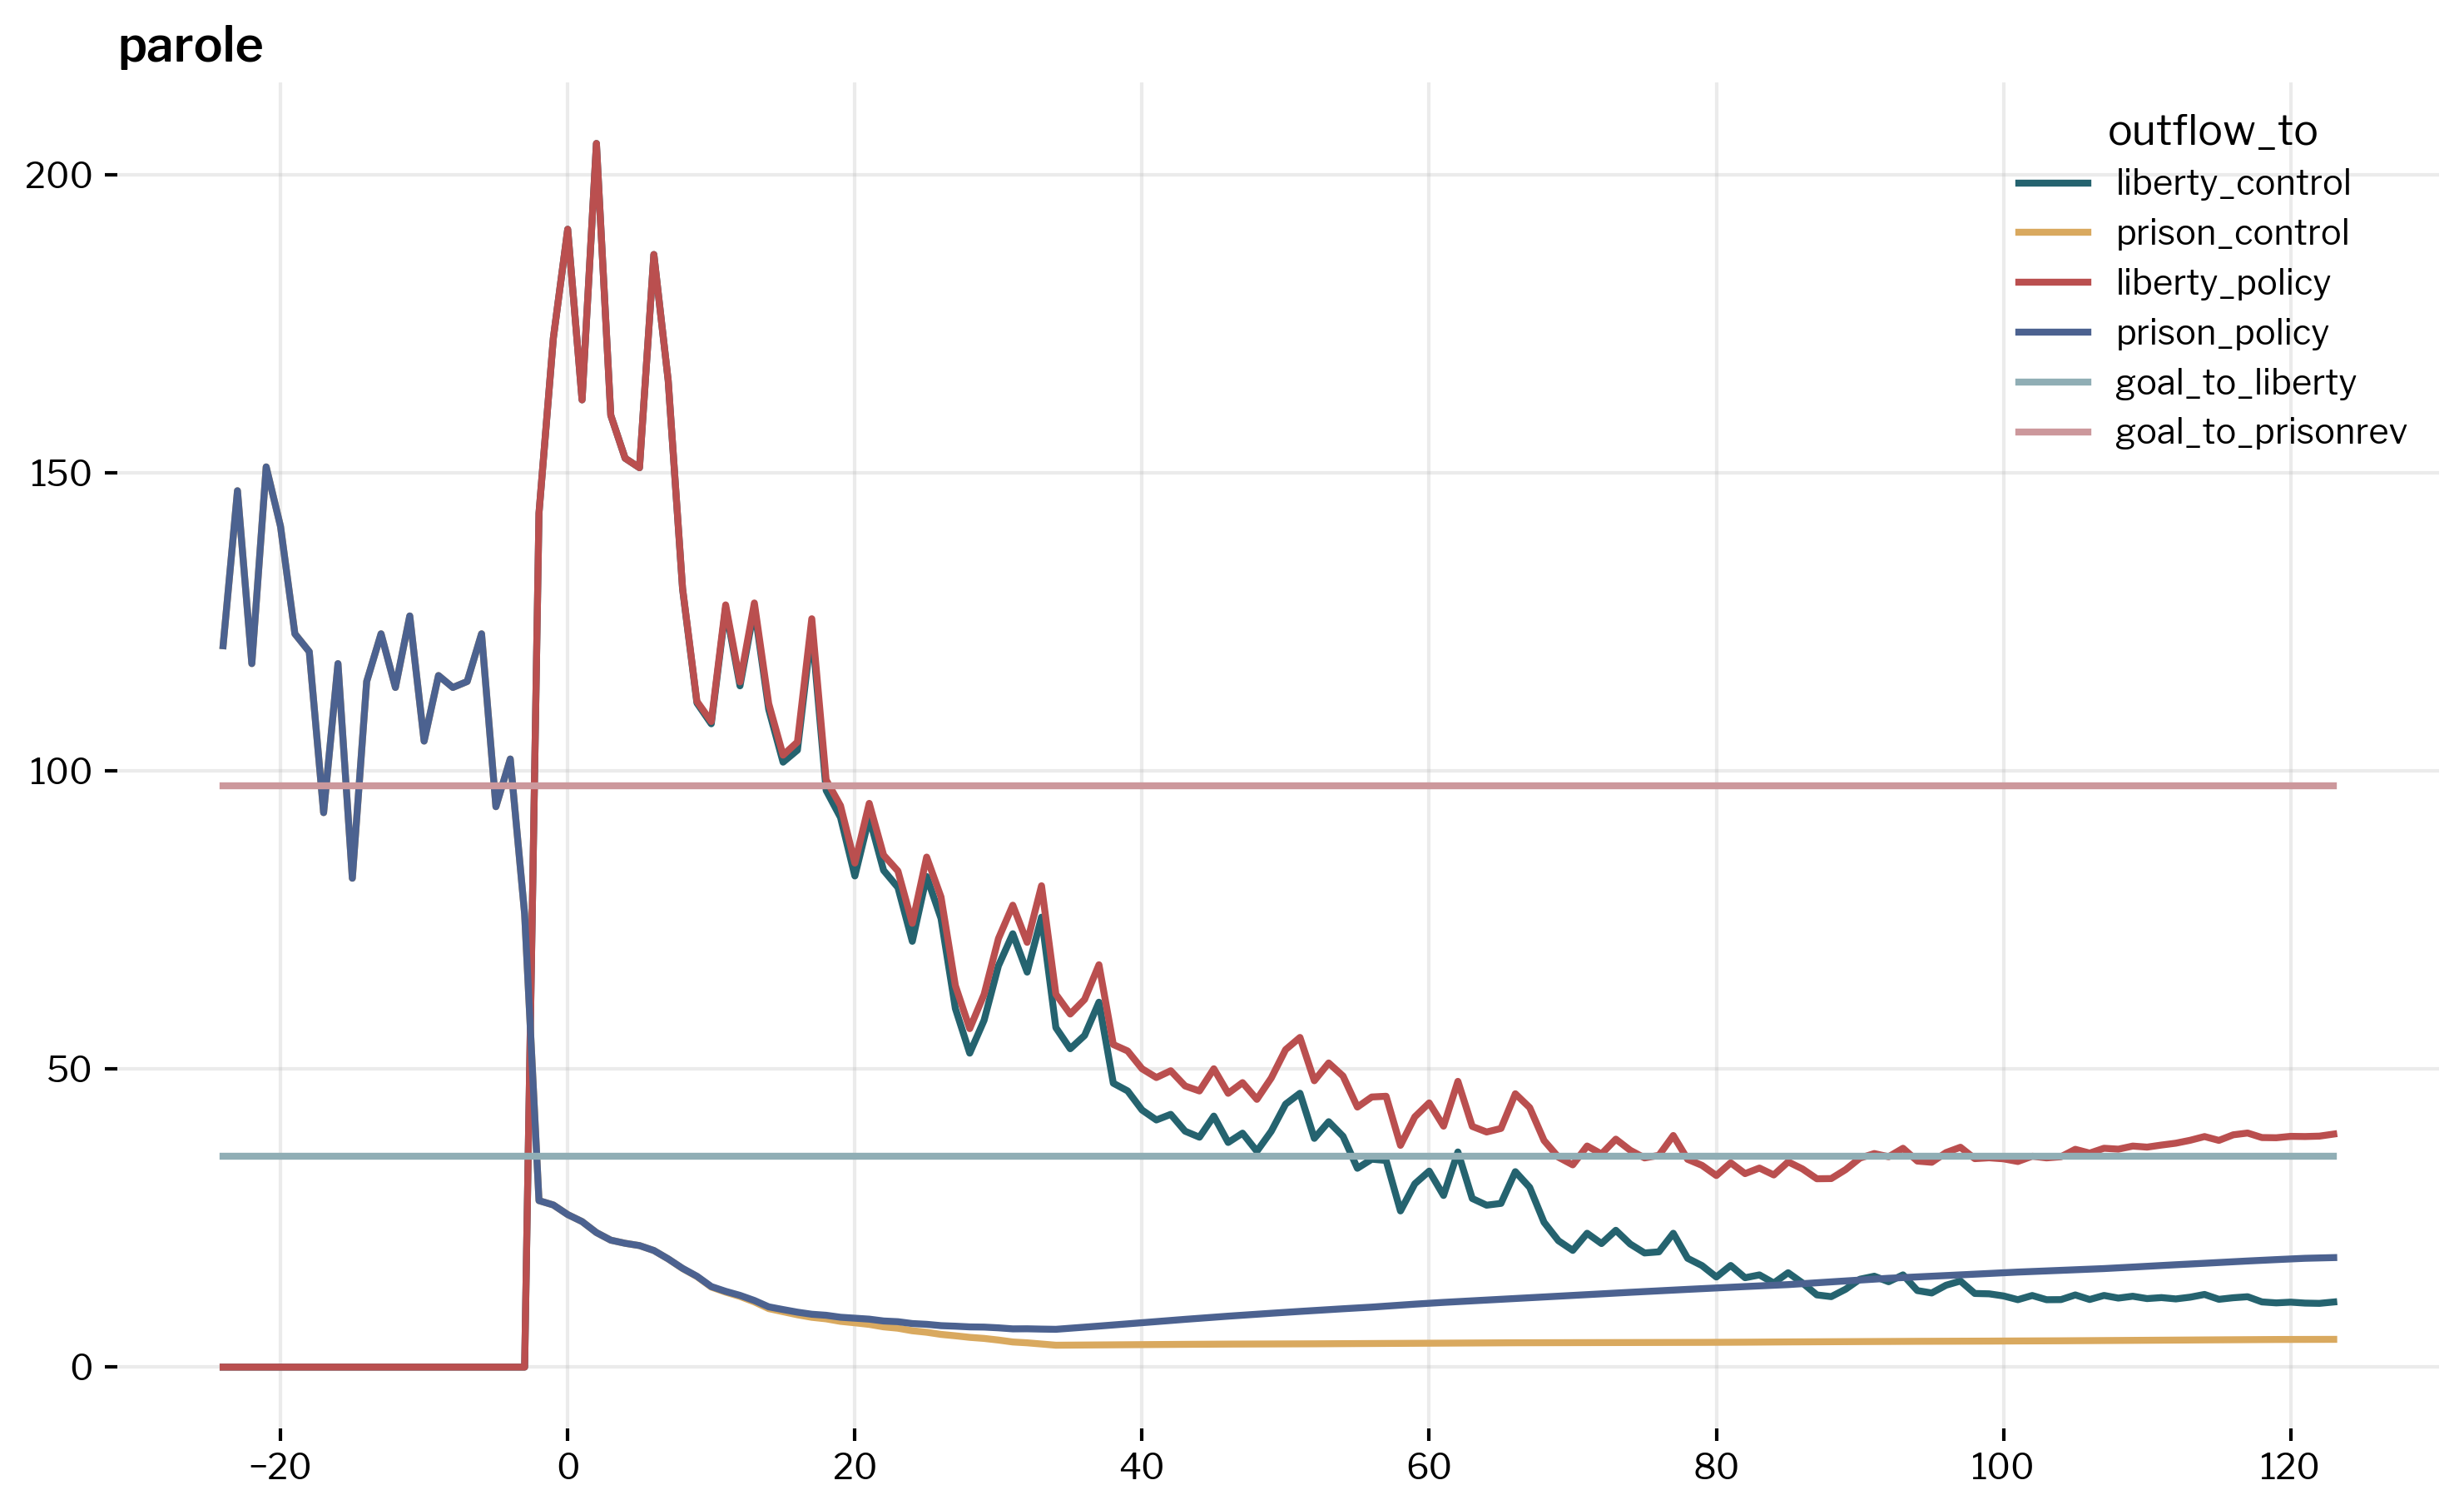

In [76]:
for c in ["pretrial", "prison", "parole"]:
    display(f"{c}")
    ctrl_policy_list = []
    for s, subsim in subsimd.items():
        summed = (
            subsim["violent"].simulation_compartments[c].outflows.loc[:, -24:]
            + subsim["nonviolent"].simulation_compartments[c].outflows.loc[:, -24:]
        ).T.add_suffix(f"_{s}")
        display(summed.head())
        if c == "parole":
            summed[f"prison_{s}"] = summed[f"prisonrev_{s}"].combine_first(
                summed[f"prison_{s}"]
            )
            summed = summed.drop(columns=[f"prisonrev_{s}"])
        ctrl_policy_list.append(summed)
    prison_new_adm_df = pd.concat(ctrl_policy_list, axis=1).fillna(0)
    prison_new_adm_df = prison_new_adm_df.loc[:, (prison_new_adm_df != 0).any(axis=0)]

    display(prison_new_adm_df.T)
    if c in desired_outflows.keys():
        for outflow, goal_outflow in desired_outflows[c].items():
            prison_new_adm_df[f"goal_to_{outflow}"] = goal_outflow
    prison_new_adm_df.plot()
    plt.title(f"{c}")

## total population

In [77]:
policy_results[policy_results.compartment == "prisonrev"].head()

,compartment,control_total_population,simulation_group,policy_total_population,population_difference,compartment_grouped
year,,,,,,
2022.916667,prisonrev,1442.109022,nonviolent,1442.109022,0.0,prison
2023.000000,prisonrev,1408.269122,nonviolent,1408.269122,0.0,prison
2023.083333,prisonrev,1375.146560,nonviolent,1375.146560,0.0,prison
2023.166667,prisonrev,1343.495689,nonviolent,1343.495689,0.0,prison
2023.250000,prisonrev,1312.049716,nonviolent,1312.049716,0.0,prison


/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_3588/1324381526.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for compartment, results in policy_results.groupby(["compartment"]):


,crime_type,compartment,year,total_population
0,nonviolent,parole,2021.000000,3021.0
1,nonviolent,parole,2021.083333,3008.0
2,nonviolent,parole,2021.166667,3012.0
3,nonviolent,parole,2021.250000,2971.0
4,nonviolent,parole,2021.333333,2947.0
5,nonviolent,parole,2021.416667,2883.0
6,nonviolent,parole,2021.500000,2843.0
7,nonviolent,parole,2021.583333,2786.0
8,nonviolent,parole,2021.666667,2739.0
9,nonviolent,parole,2021.750000,2709.0


,crime_type,compartment,year,total_population
0,nonviolent,prison,2017.000000,5113.783247
1,nonviolent,prison,2017.083333,5096.784399
2,nonviolent,prison,2017.166667,5038.723399
3,nonviolent,prison,2017.250000,4994.570548
4,nonviolent,prison,2017.333333,4925.912864
5,nonviolent,prison,2017.416667,4901.187267
6,nonviolent,prison,2017.500000,4827.672770
7,nonviolent,prison,2017.583333,4772.040177
8,nonviolent,prison,2017.666667,4760.339671
9,nonviolent,prison,2017.750000,4748.418401


<Figure size 3600x2100 with 0 Axes>

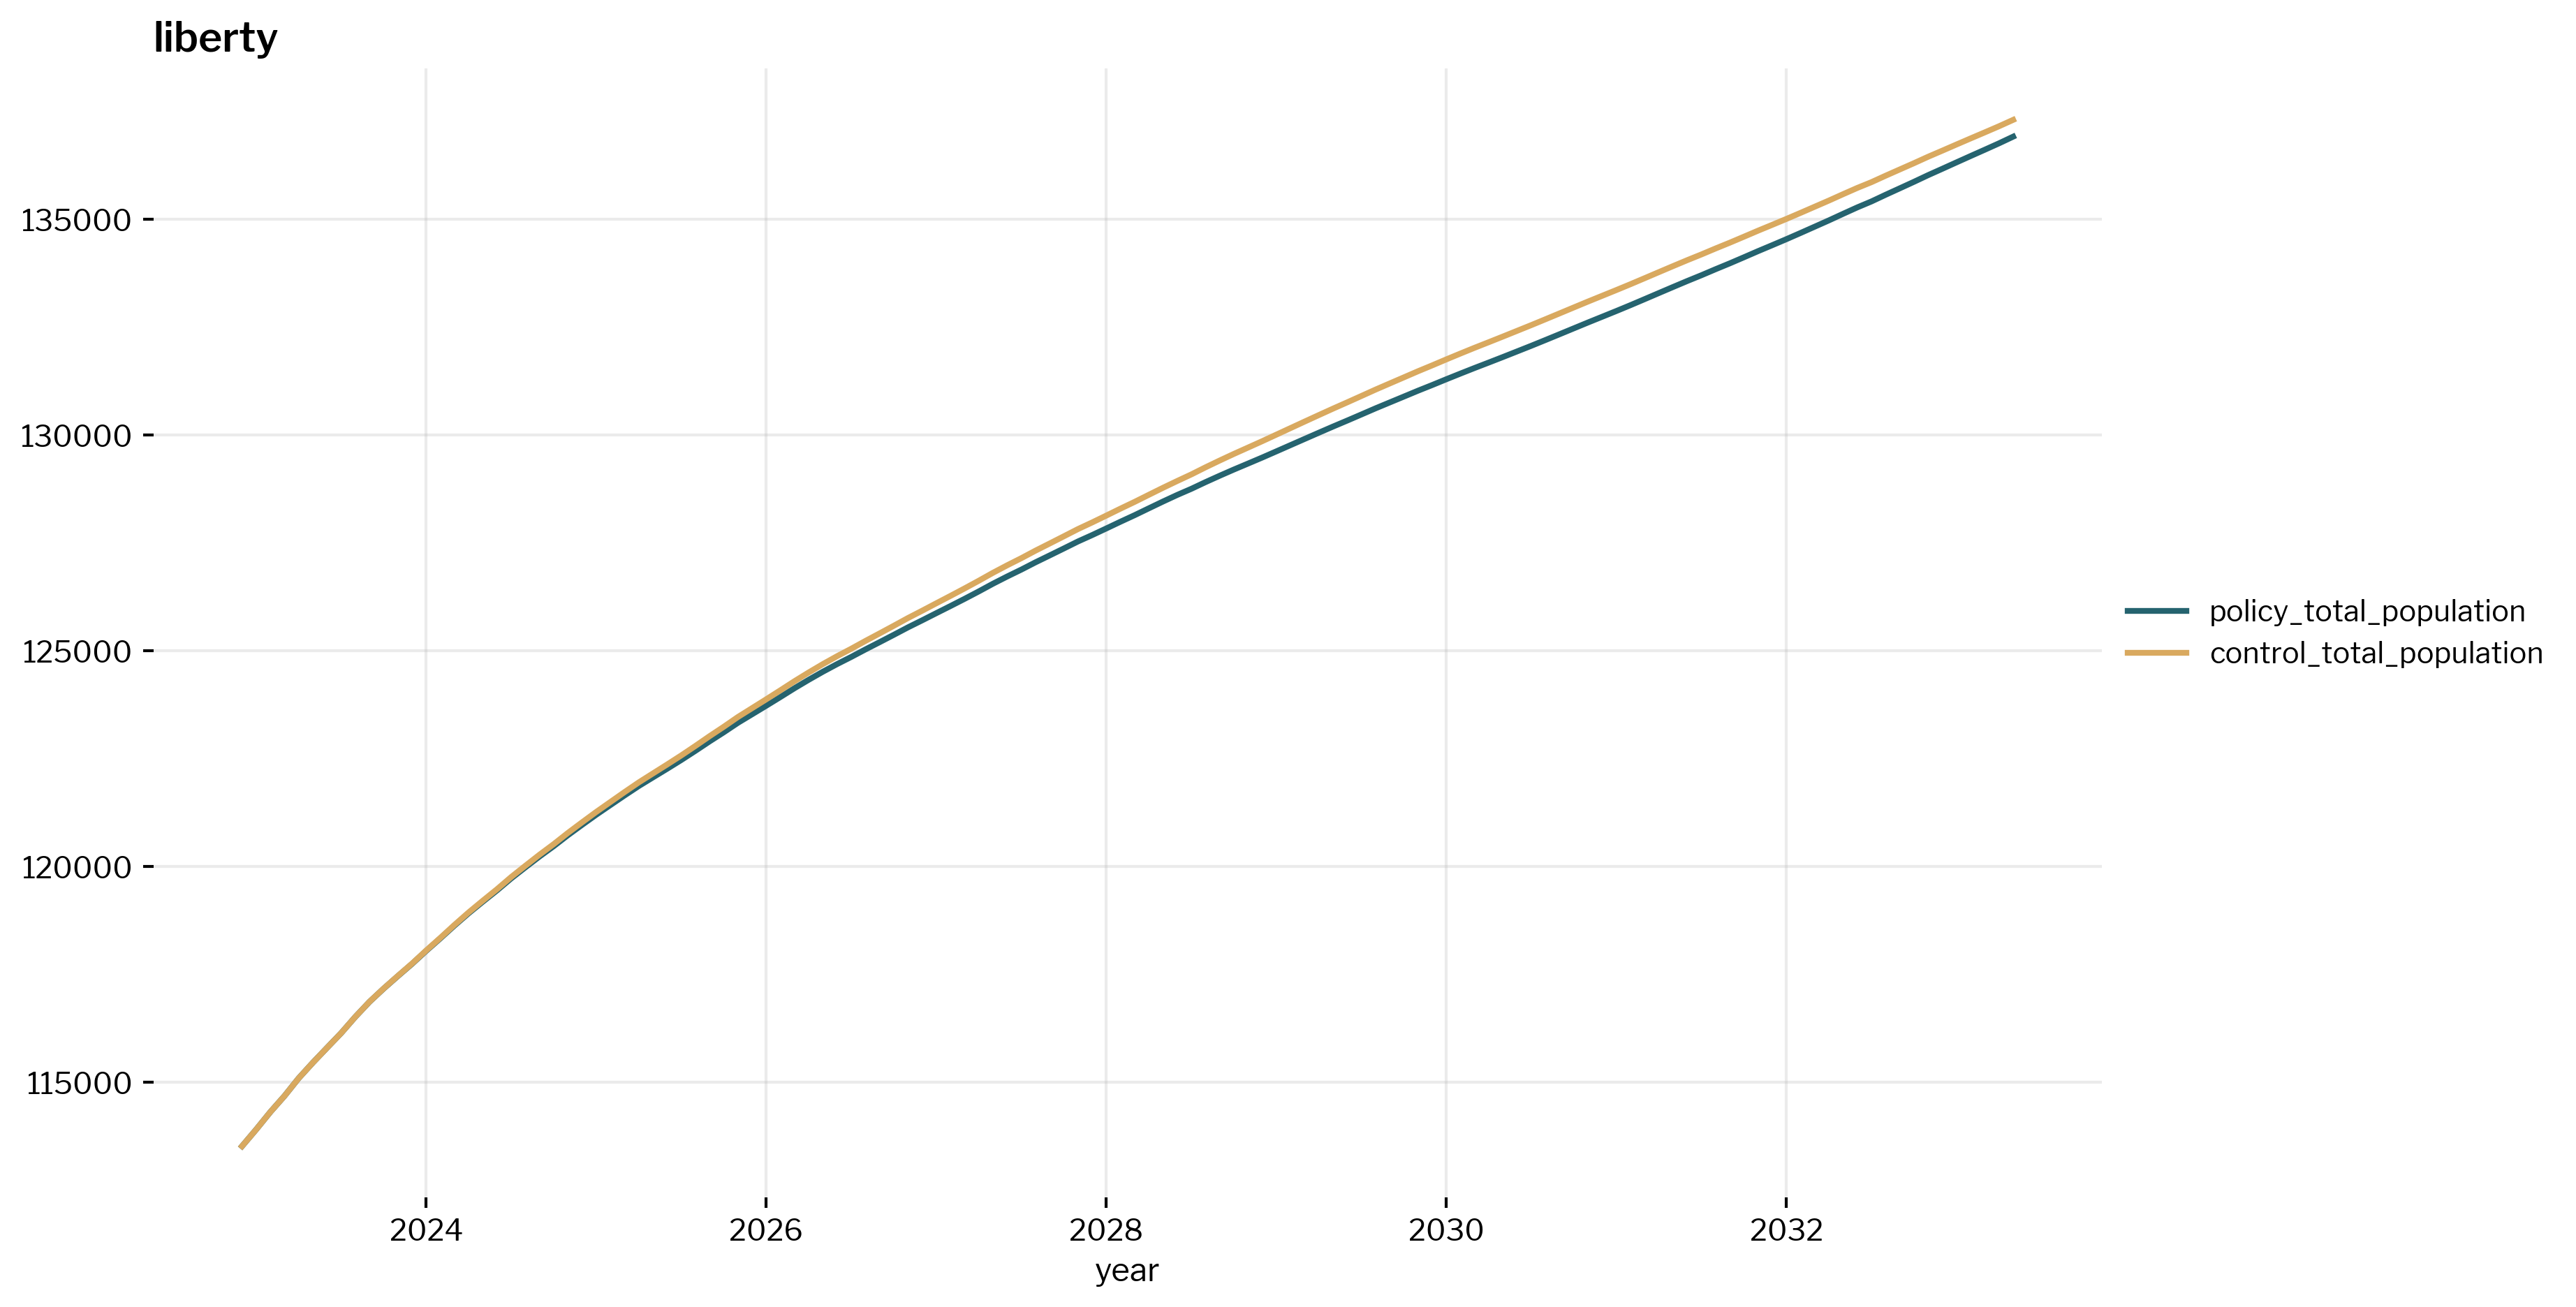

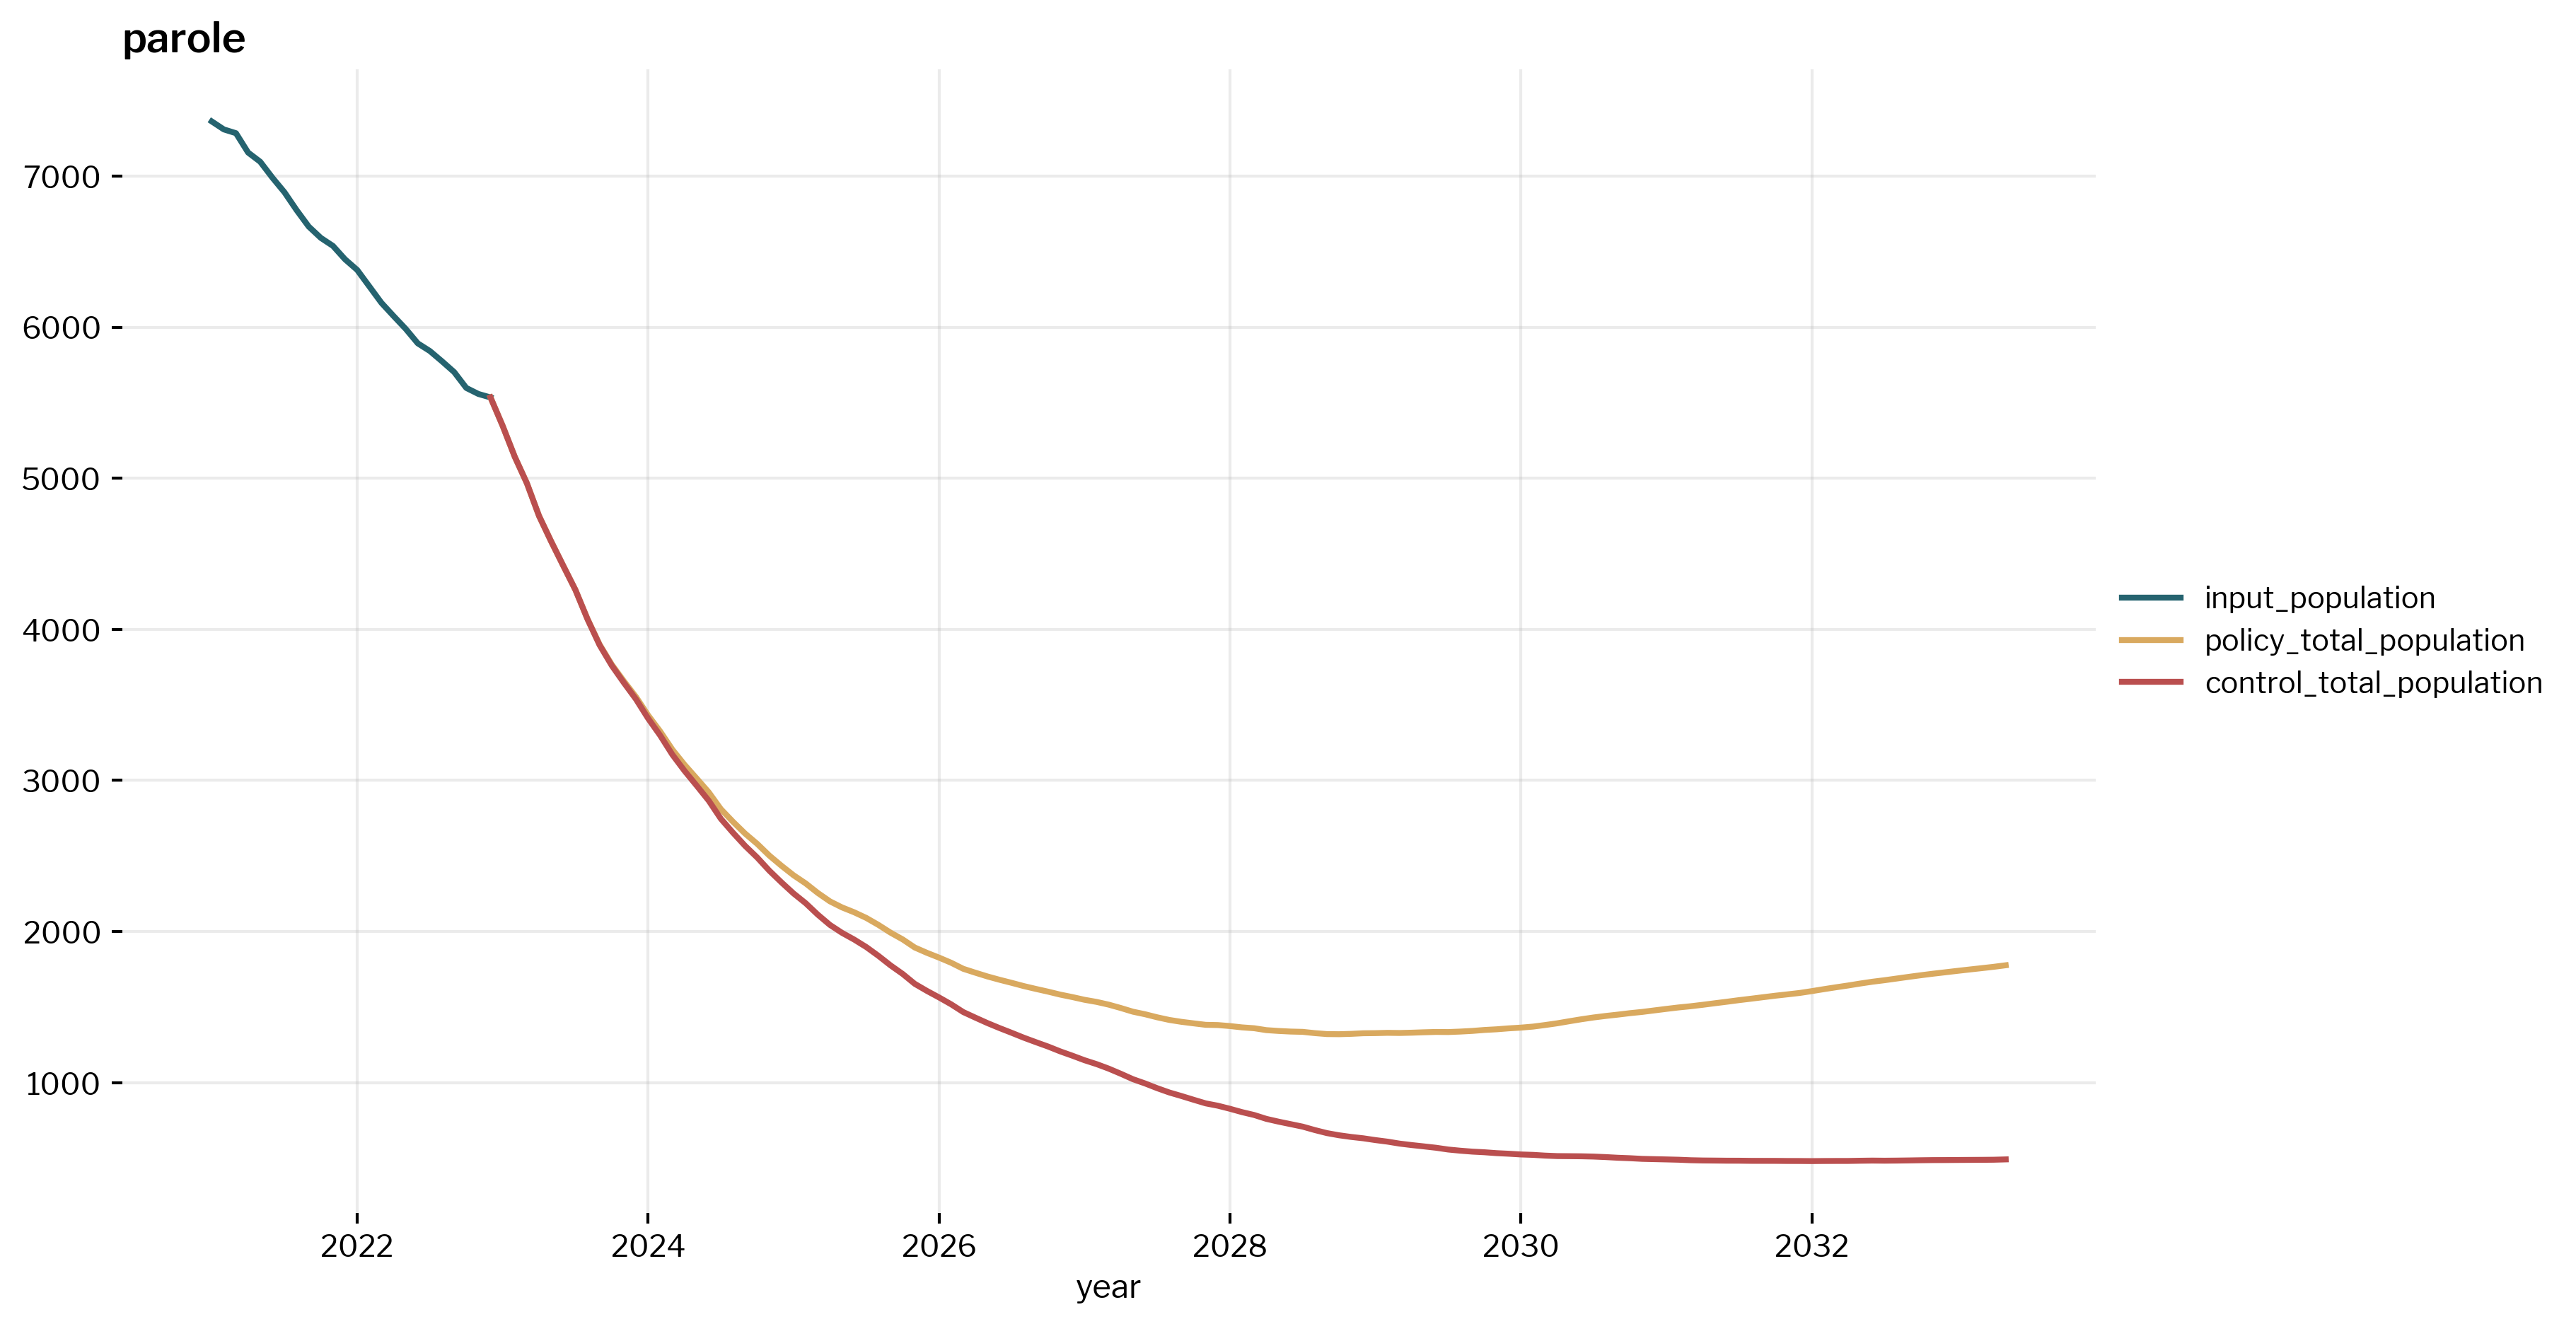

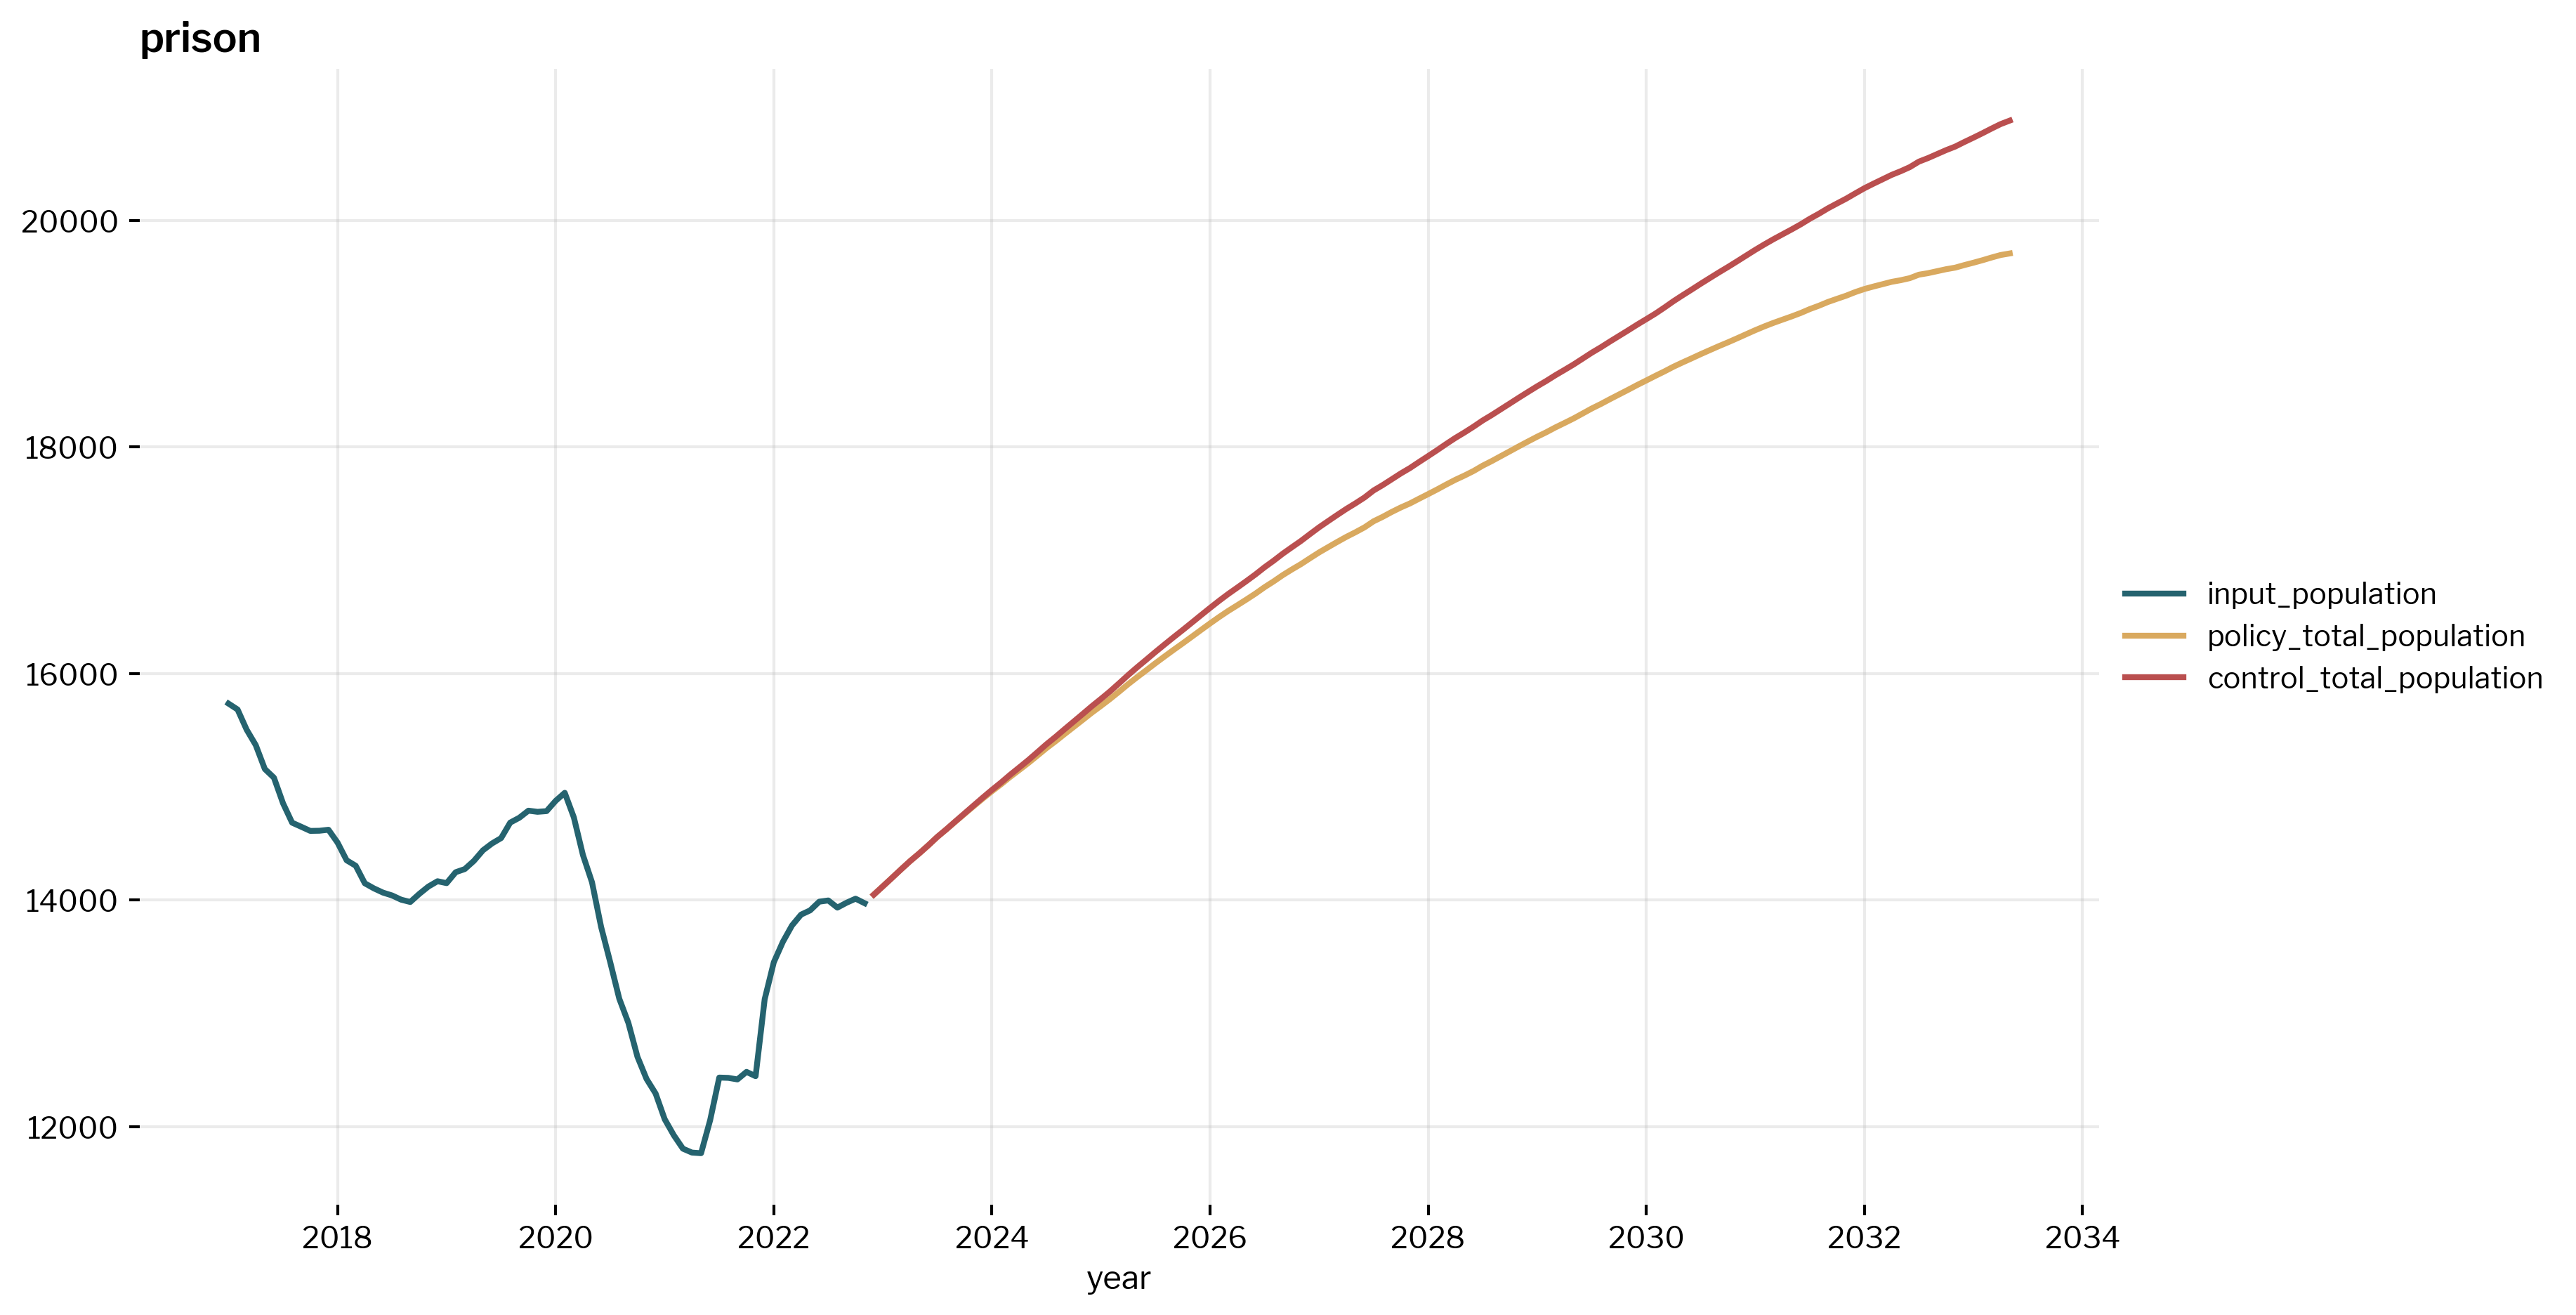

<Figure size 3600x2100 with 0 Axes>

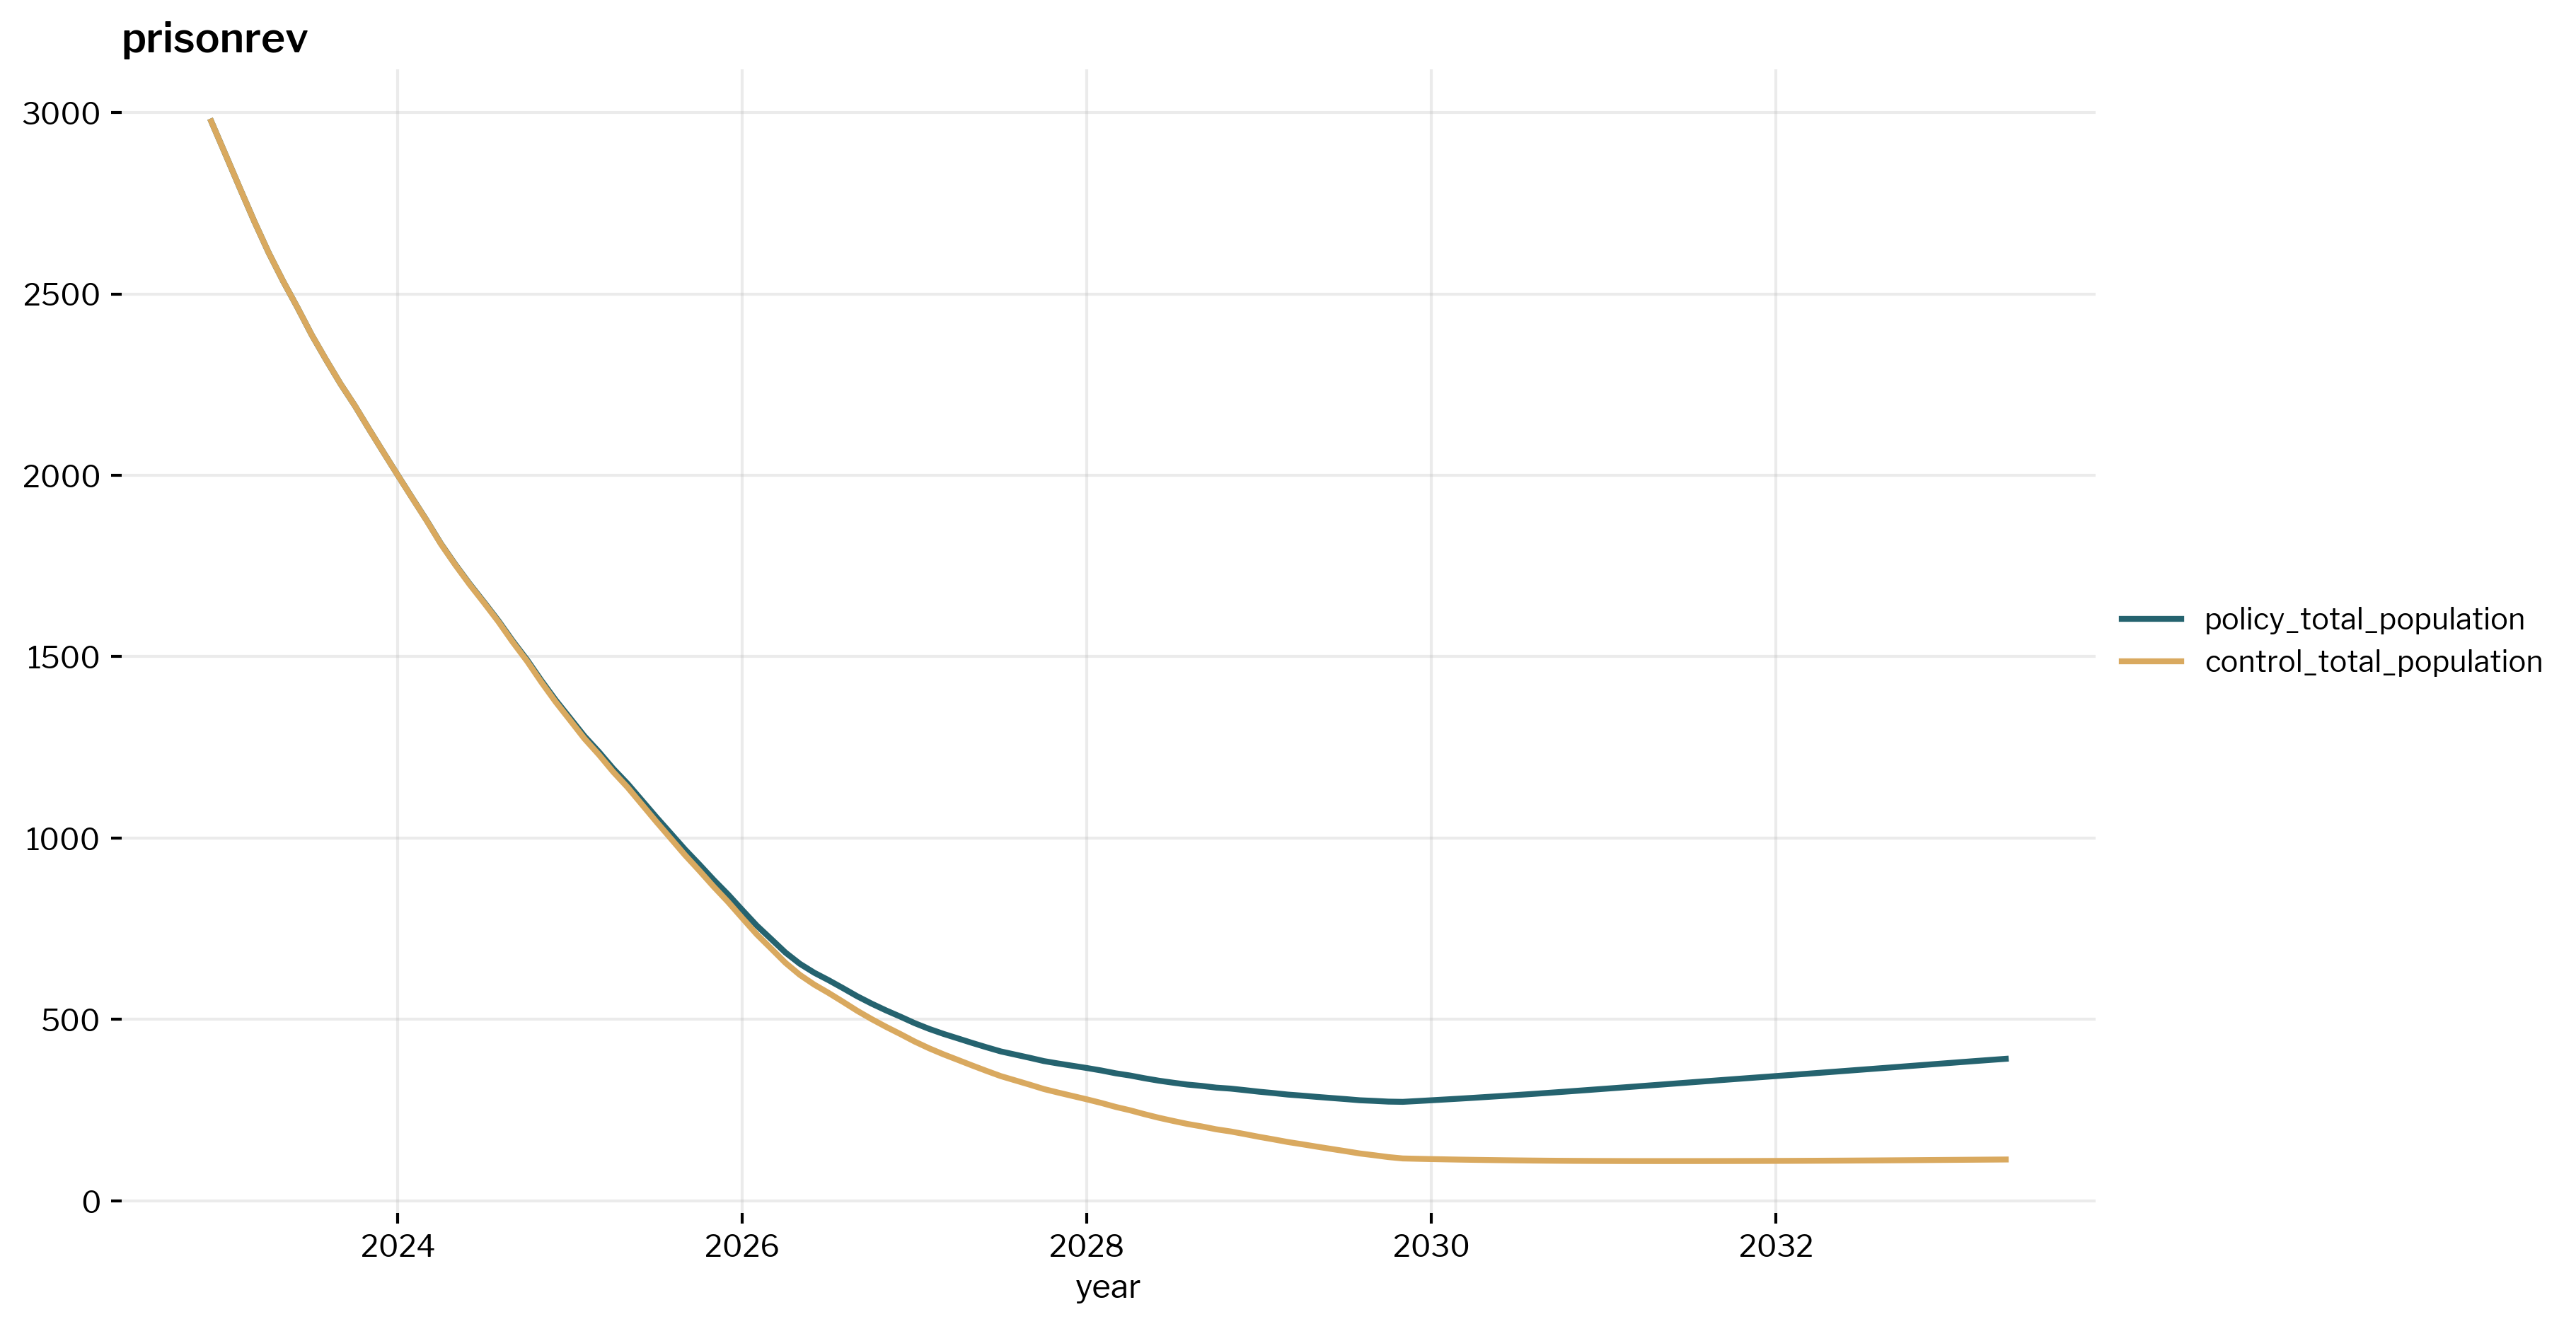

In [78]:
total_population_data = policy_sim.initializer.data_inputs.total_population_data.copy()
total_population_data[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    total_population_data["time_step"]
)
total_population_data = total_population_data.set_index(
    ["crime_type", "compartment", "year"]
).sort_index()["total_population"]

for compartment, results in policy_results.groupby(["compartment"]):
    plt.figure()
    ax = None
    if compartment in total_population_data.index.get_level_values("compartment"):
        #         display(total_population_data[
        #                     total_population_data.index.get_level_values("compartment")
        #                     == compartment
        #                 ].reset_index())
        display(
            pd.concat(
                [
                    total_population_data[
                        total_population_data.index.get_level_values("compartment")
                        == compartment
                    ].reset_index(),
                    results[results.compartment == "prisonrev"][
                        ["compartment", "control_total_population"]
                    ]
                    .rename(columns={"control_total_population": "total_population"})
                    .reset_index(),
                ]
            )
        )
        ax = (
            total_population_data[
                total_population_data.index.get_level_values("compartment")
                == compartment
            ]
            .groupby("year")
            .sum()
            .plot(label="input_population")
        )
    results.groupby("year")[
        ["policy_total_population", "control_total_population"]
    ].sum().plot(ax=ax)
    add_legend()
    plt.title(f"{compartment}")

In [79]:
subsim["violent"].simulation_compartments

{'pretrial': <recidiviz.calculator.modeling.population_projection.shell_compartment.ShellCompartment at 0x16d547fd0>,
 'prison': <recidiviz.calculator.modeling.population_projection.full_compartment.FullCompartment at 0x16ae340d0>,
 'parole': <recidiviz.calculator.modeling.population_projection.full_compartment.FullCompartment at 0x16d678790>,
 'prisonrev': <recidiviz.calculator.modeling.population_projection.full_compartment.FullCompartment at 0x16aca29d0>,
 'liberty': <recidiviz.calculator.modeling.population_projection.full_compartment.FullCompartment at 0x16aca2be0>}

'prison'

,0,12,24,36,48,60,72,84,96,108,120
control,17004.360695,16971.653977,17100.299959,17357.869841,17729.884106,18199.326773,18712.292257,19243.337182,19850.445684,20394.576604,20843.732257
policy,17004.360695,16960.204408,17044.411122,17243.337676,17558.977026,17950.031566,18391.676804,18864.338691,19340.181991,19738.826570,20006.706981
diff,0.000000,11.449569,55.888837,114.532165,170.907080,249.295207,320.615453,378.998491,510.263693,655.750033,837.025276


'parole'

,0,12,24,36,48,60,72,84,96,108,120
control,5346.967455,3410.562110,2251.966635,1563.840896,1148.234479,826.832585,619.578428,524.479798,491.582893,480.551492,487.975074
policy,5346.967455,3431.343692,2372.390700,1827.403497,1548.212847,1374.368211,1327.473921,1363.965316,1487.889860,1605.533682,1739.482689
diff,0.000000,-20.781581,-120.424064,-263.562601,-399.978368,-547.535627,-707.895493,-839.485518,-996.306967,-1124.982190,-1251.507615


'liberty'

,0,12,24,36,48,60,72,84,96,108,120
control,113898.75382,118049.865171,121261.813958,123874.369370,126099.961559,128133.920414,130010.208949,131756.262599,133364.051377,135012.952171,136738.372771
policy,113898.75382,118040.533366,121197.277908,123725.336778,125870.886688,127835.672460,129622.916640,131295.756825,132877.983463,134543.690376,136323.854989
diff,0.00000,9.331805,64.536049,149.032592,229.074871,298.247954,387.292310,460.505774,486.067914,469.261795,414.517782


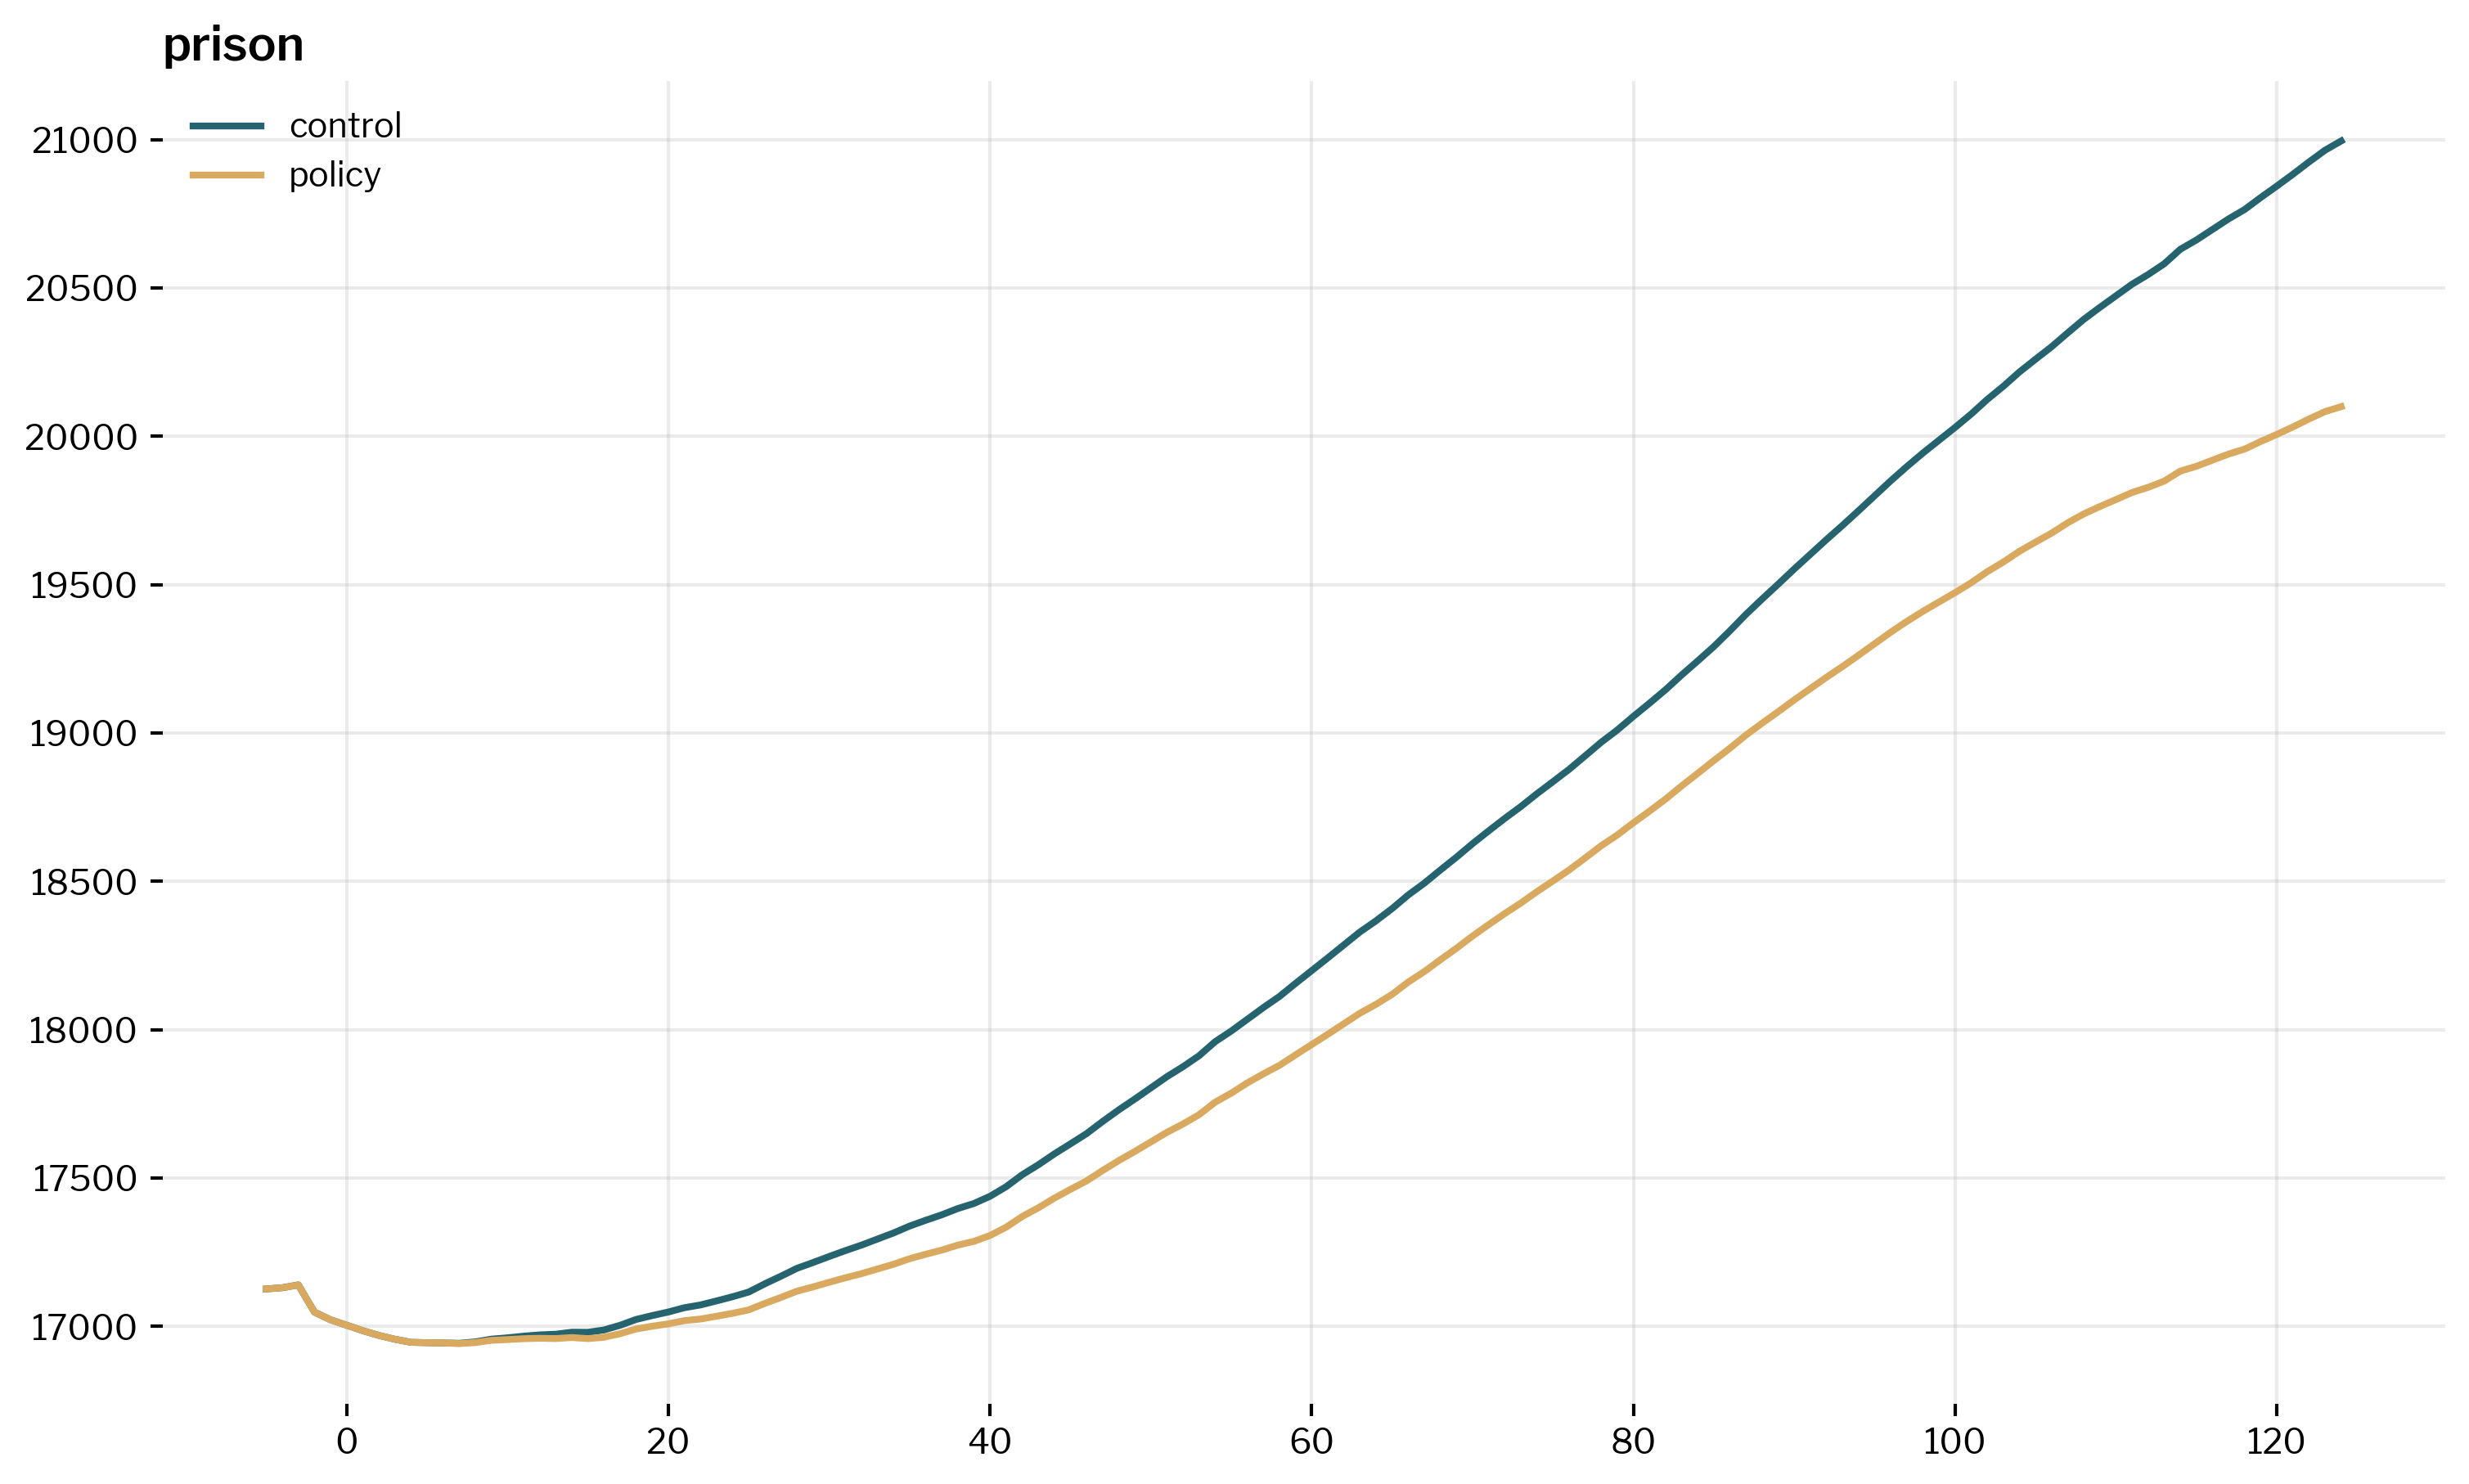

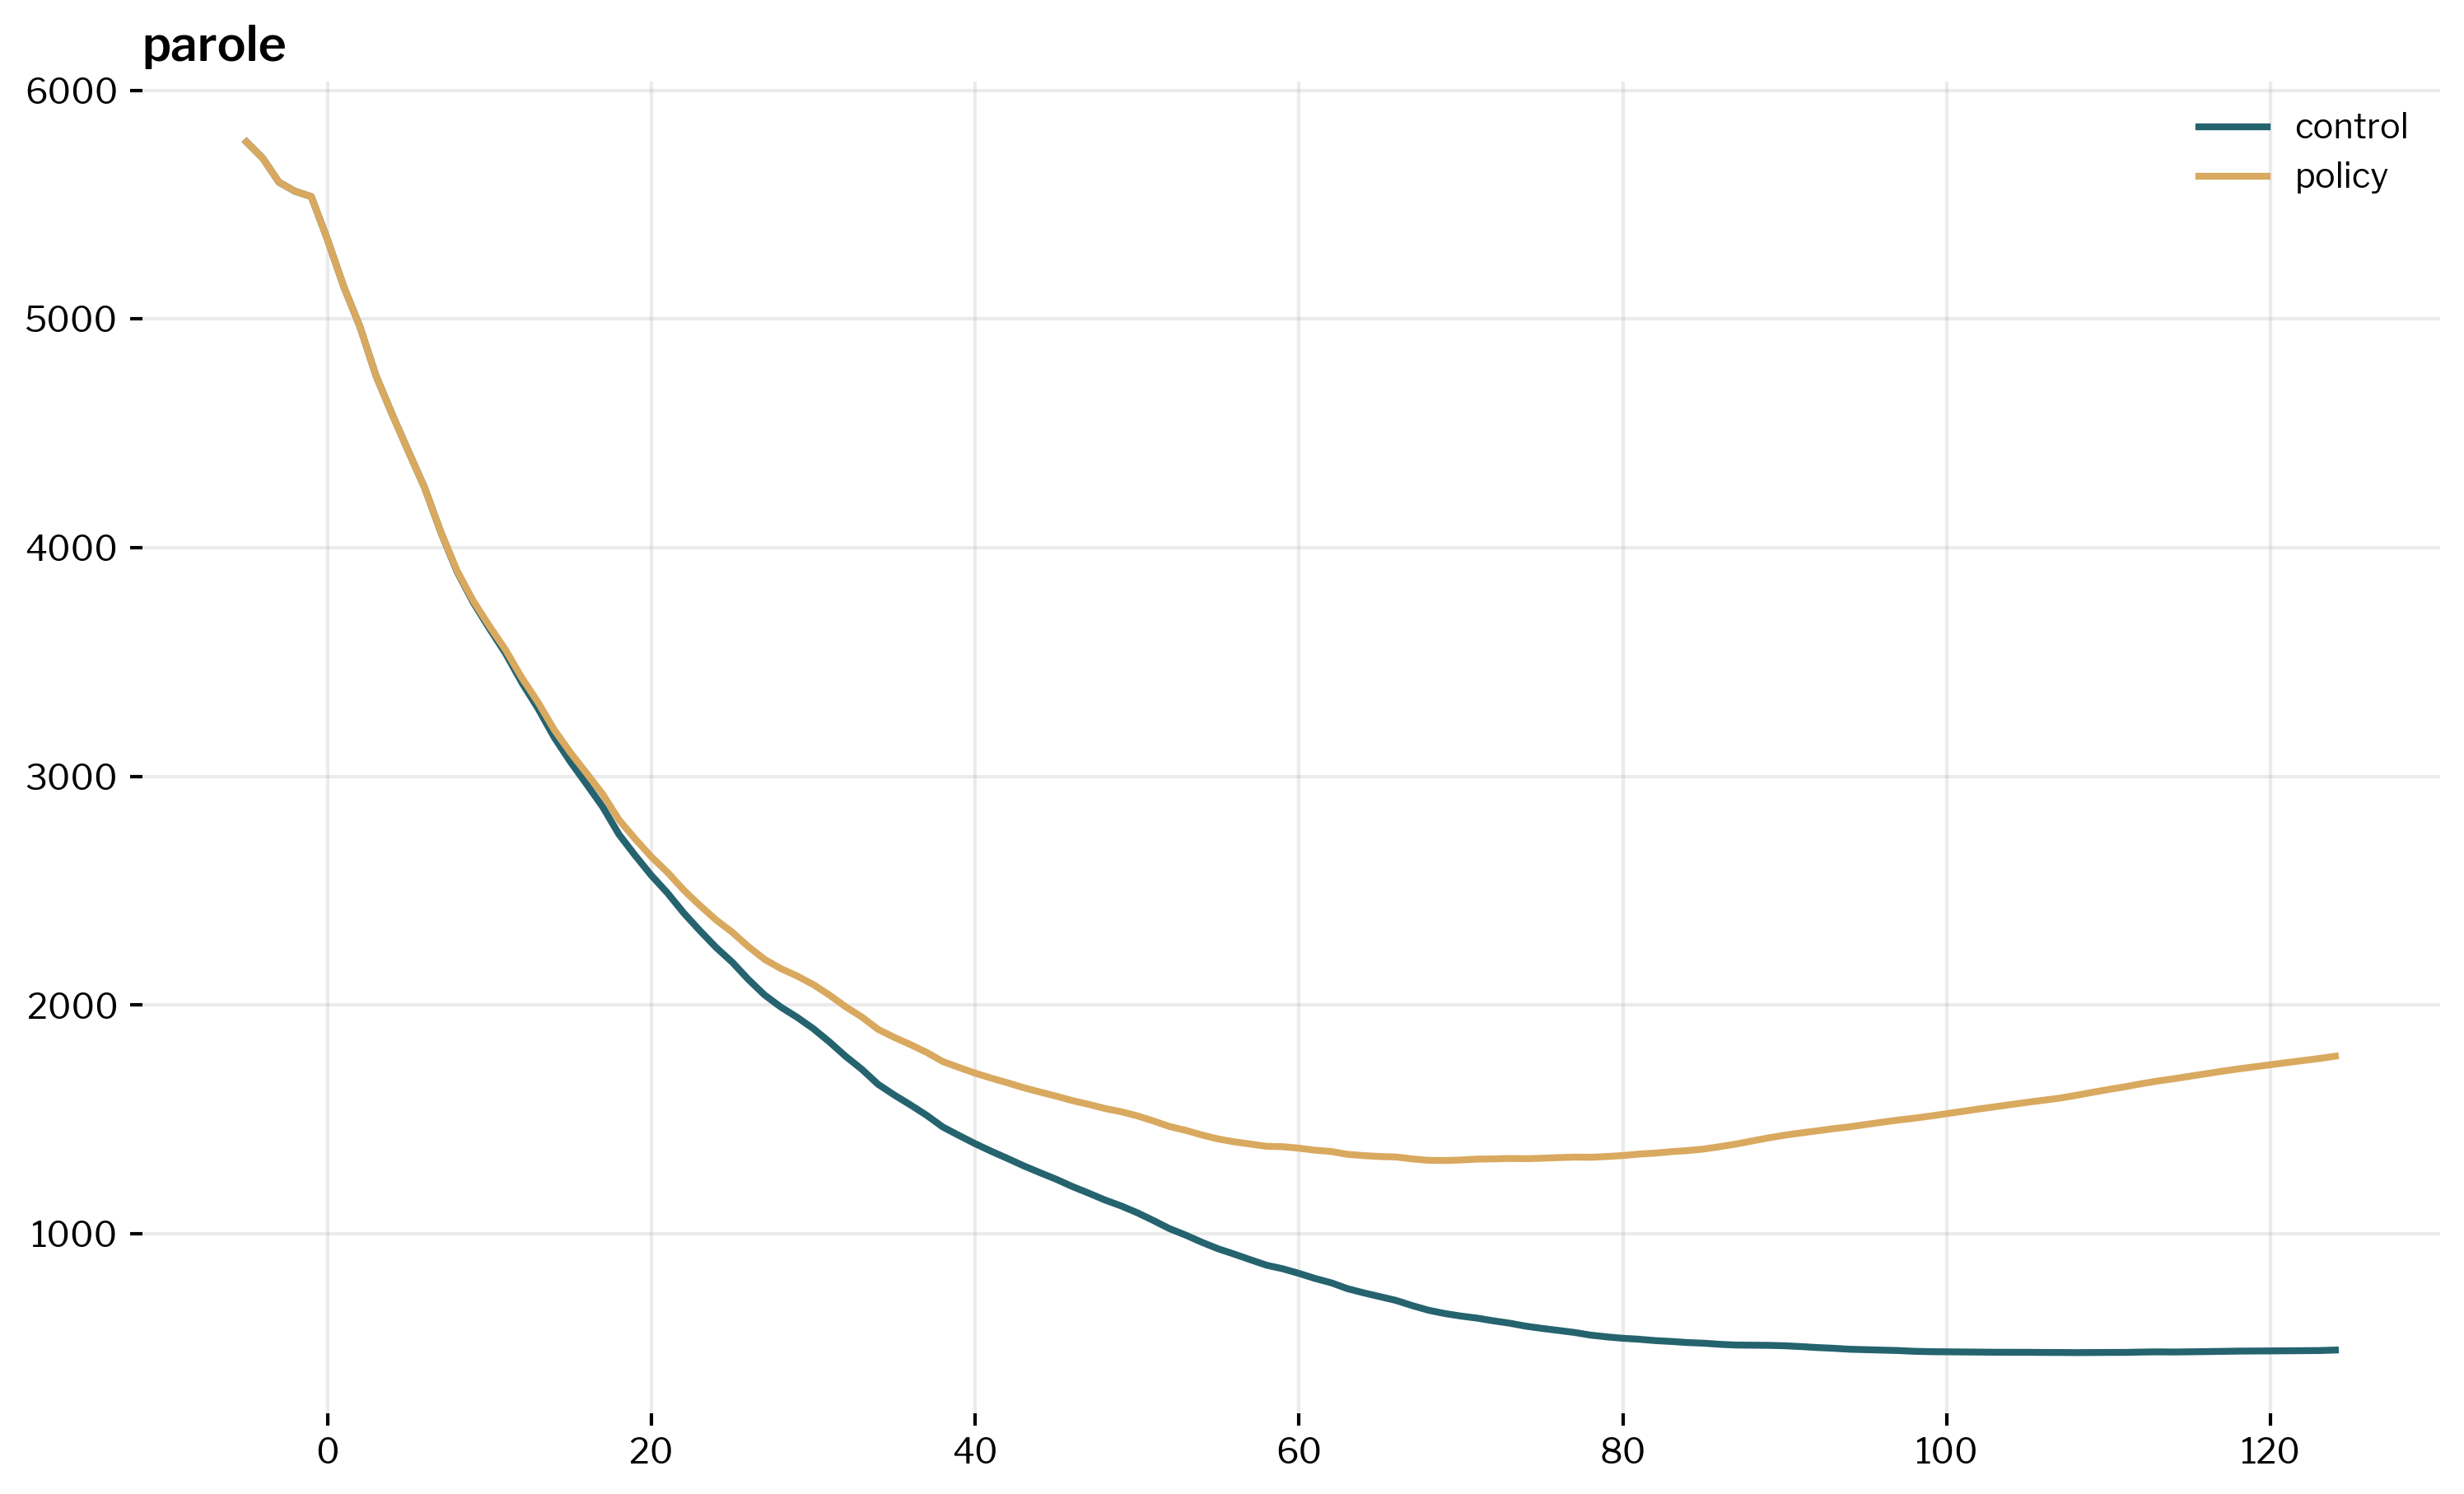

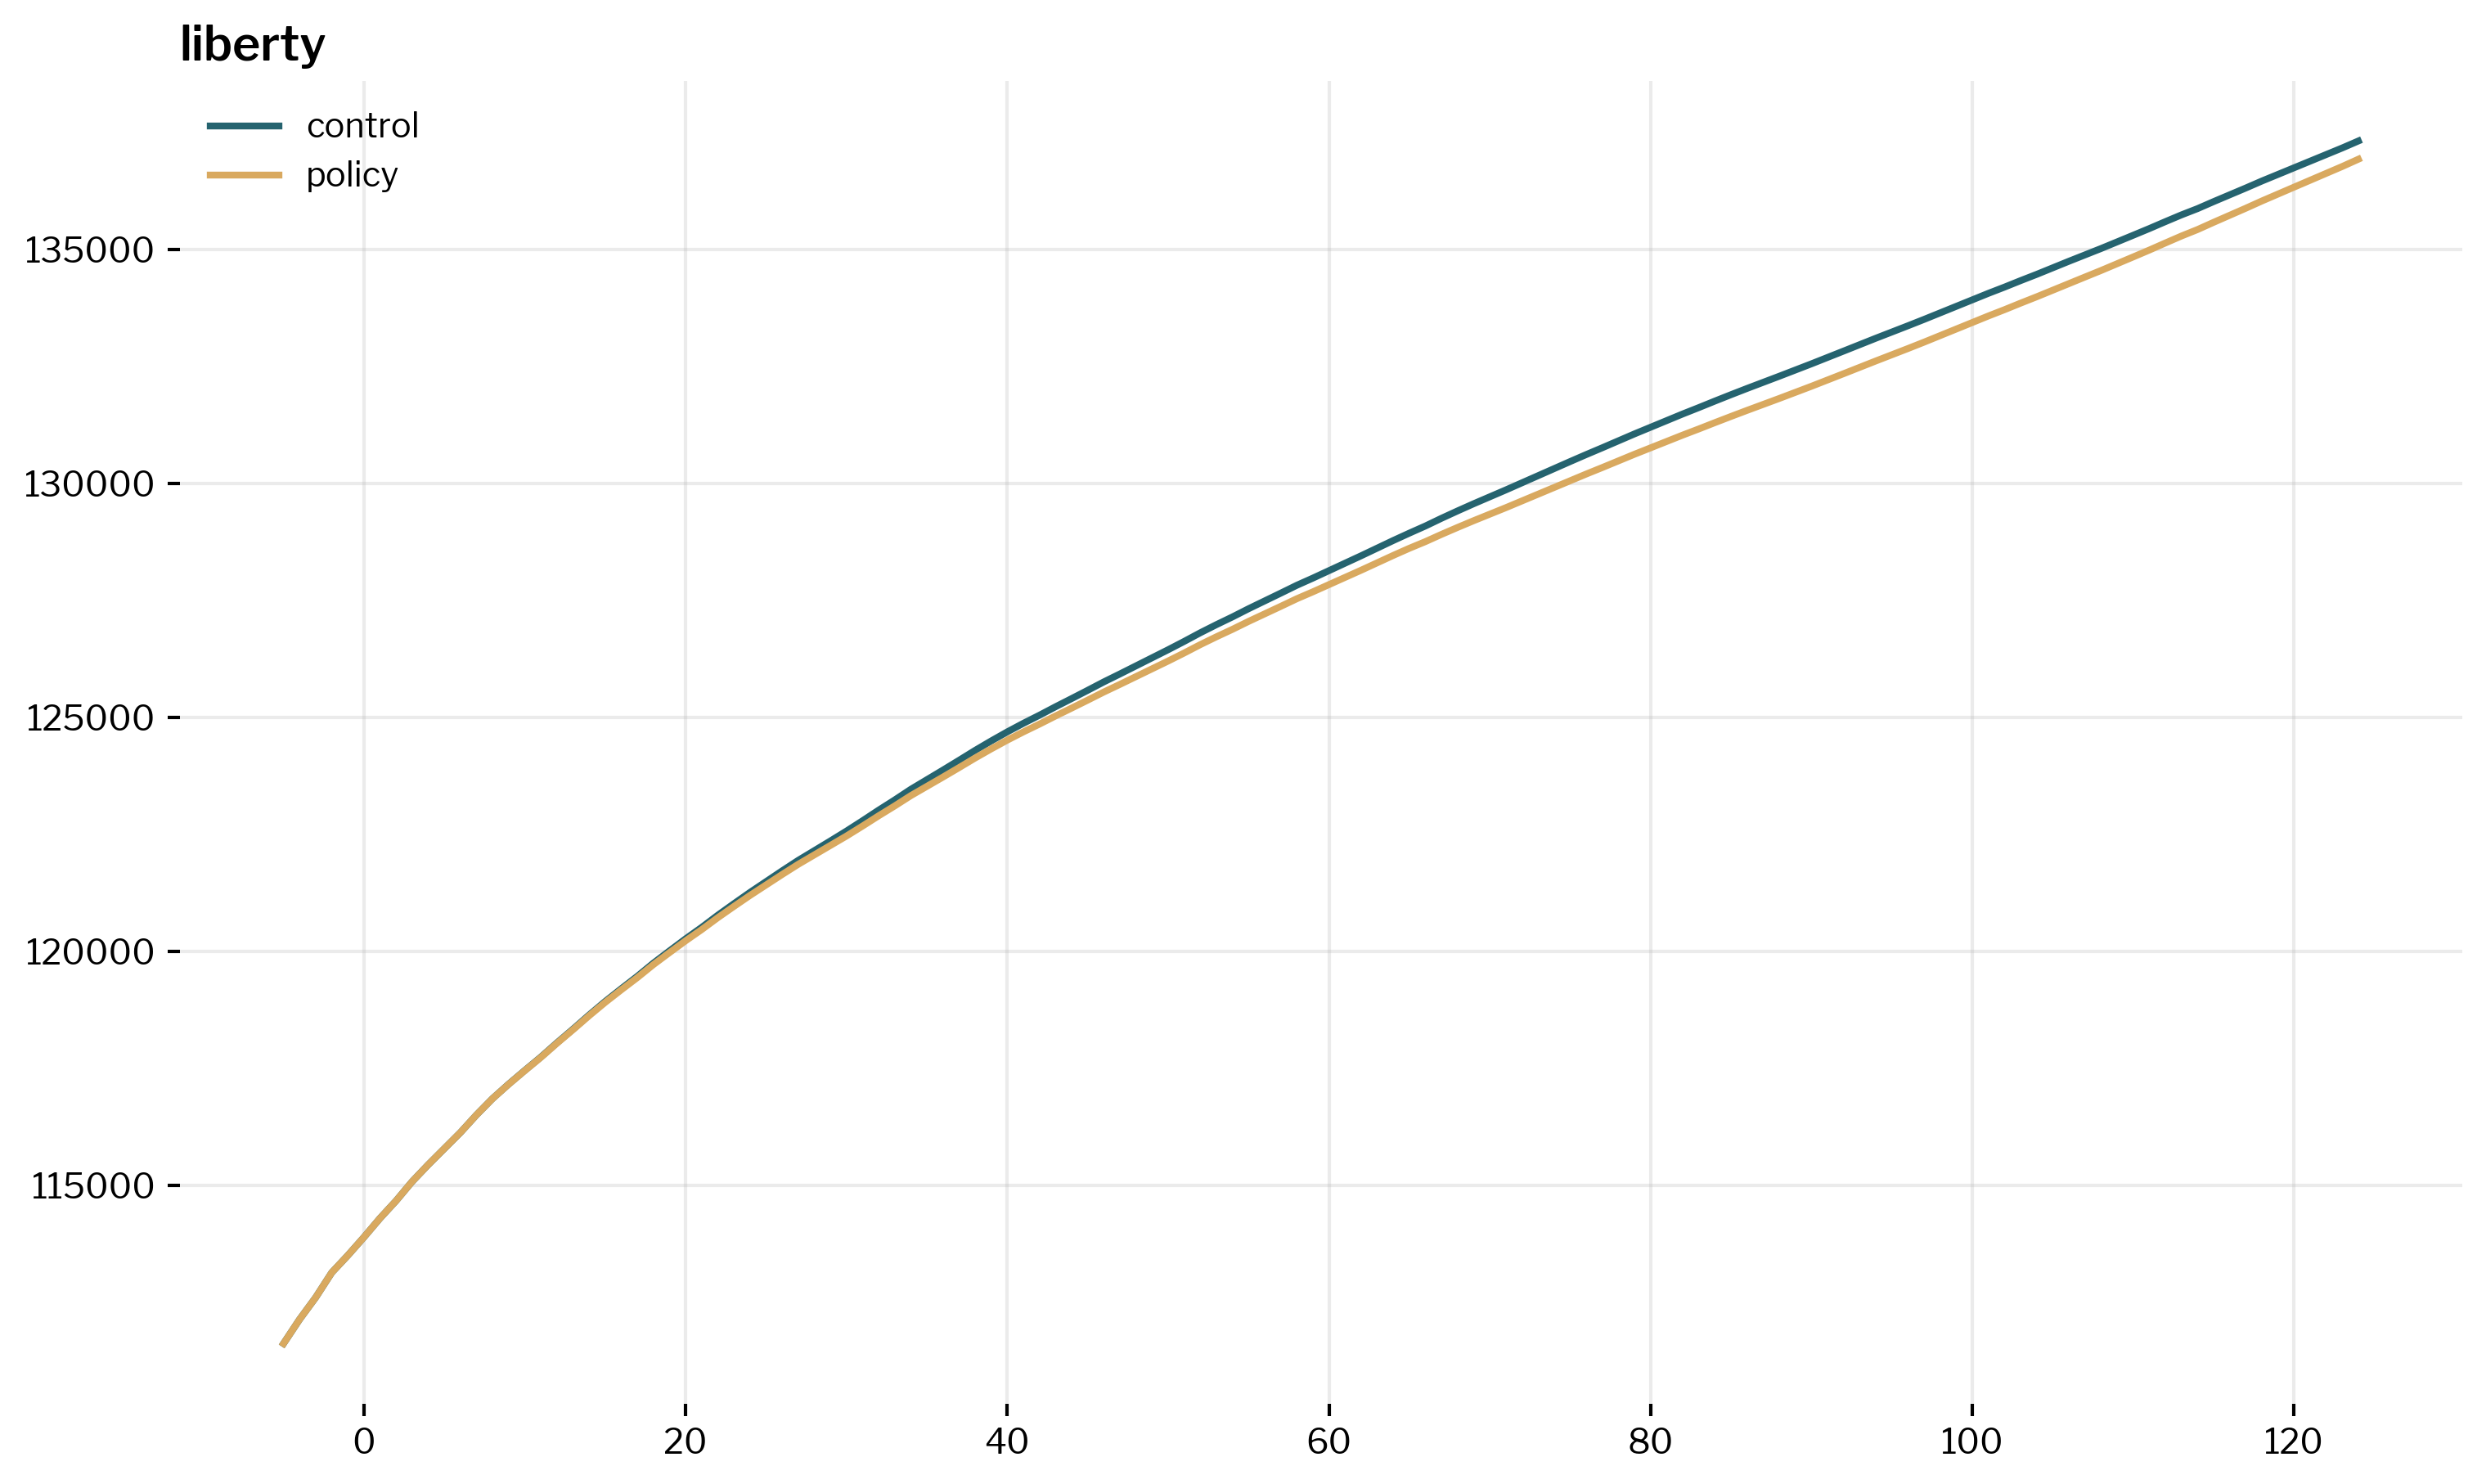

In [80]:
for c in ["prison", "parole", "liberty"]:
    ctrl_policy_list = []
    for s, subsim in subsimd.items():
        summed = pd.DataFrame(
            subsim["violent"].simulation_compartments[c].end_ts_populations, columns=[s]
        ) + pd.DataFrame(
            subsim["nonviolent"].simulation_compartments[c].end_ts_populations,
            columns=[s],
        )
        if c == "prison":
            summed = summed + (
                pd.DataFrame(
                    subsim["violent"]
                    .simulation_compartments["prisonrev"]
                    .end_ts_populations,
                    columns=[s],
                )
                + pd.DataFrame(
                    subsim["nonviolent"]
                    .simulation_compartments["prisonrev"]
                    .end_ts_populations,
                    columns=[s],
                )
            )
        ctrl_policy_list.append(summed)
    pop_df = pd.concat(ctrl_policy_list, axis=1).loc[-5:]
    display(f"{c}")
    pop_results = pop_df.loc[np.arange(0, 121, 12)]
    pop_results["diff"] = pop_df.control - pop_df.policy
    display(pop_results.T)
    pop_df.plot()
    plt.title(f"{c}")

In [ ]:
for c in comp:
    ctrl_policy_list = []
    for s, subsim in subsimd.items():
        prison_new_admissions = (
            (
                subsim["violent"].simulation_compartments[c].outflows.loc[:, -10:60]
                + subsim["nonviolent"]
                .simulation_compartments[c]
                .outflows.loc[:, -10:60]
            )
            .T.add_suffix(f"_{s}")
            .T
        )  # .reset_index().rename(columns={'outflow_to':f"{c}_{s}"})
        display(f"{c}_{s}")
        display(prison_new_admissions.head())
        prison_new_admissions.plot()
        plt.title(f"{c}_{s}")
        ctrl_policy_list.append(prison_new_admissions)
    prison_new_adm_df = pd.concat(ctrl_policy_list, axis=1)
    prison_new_adm_df.plot()
    plt.title(f"{c}")
    display(prison_new_adm_df.head(20))

In [ ]:
subsim["violent"].simulation_compartments["parole"].outflows.loc[:, -10:].head()

In [ ]:
subsim["nonviolent"].simulation_compartments["parole"].outflows.loc[:, -10:].head()

In [ ]:
subsim["violent"].simulation_compartments["prison"].outflows.loc[:, -10:].head()

In [ ]:
subsim["nonviolent"].simulation_compartments["prison"].outflows.loc[:, -10:].head()

In [ ]:
subsim["nonviolent"].simulation_compartments["parole"].outflows.loc[:, -10:].head()

In [ ]:
(
    subsim["violent"].simulation_compartments["parole"].outflows.loc[:, -20:]
    + subsim["nonviolent"].simulation_compartments["parole"].outflows.loc[:, -20:]
)

In [ ]:
for compartment in subsim["violent"].simulation_compartments:
    cop

In [ ]:
policy_results.head()

In [ ]:
total_population_data = policy_sim.initializer.data_inputs.total_population_data.copy()
total_population_data[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    total_population_data["time_step"]
)
total_population_data = total_population_data.set_index(
    ["crime_type", "compartment", "year"]
).sort_index()["total_population"]

for compartment, results in policy_results.groupby(["compartment"]):
    plt.figure()
    ax = None
    if compartment in total_population_data.index.get_level_values("compartment"):
        ax = (
            total_population_data[
                total_population_data.index.get_level_values("compartment")
                == compartment
            ]
            .groupby("year")
            .sum()
            .plot(label="input_population")
        )
    results.groupby("year")[
        ["policy_total_population", "control_total_population"]
    ].sum().plot(ax=ax)
    add_legend()
    plt.ylim(0)
    plt.title(f"{compartment}")

In [ ]:
x = 1
for group, results in policy_results.groupby(["simulation_group", "compartment"]):
    plt.figure(x)
    plt.plot(results[["policy_total_population", "control_total_population"]])
    plt.title(f"{group}")
    x += 1
#     policy_results.reset_index().pivot(index='year',columns=['simulation_group','compartment'],values=['policy_total_population','control_total_population']).plot()

In [ ]:
x = 1
for group, results in policy_results.groupby(["simulation_group", "compartment"]):
    #     display(results.head())
    plt.figure(x)
    #     print(group)
    #     display(
    #         pd.concat(
    #             [
    #                 results.sort_values("control_total_population", ascending=False).head(
    #                     1
    #                 ),
    #                 results.sort_values("control_total_population", ascending=False).head(
    #                     1
    #                 ),
    #             ]
    #         )
    #     )
    #     print(f"maxes at ")
    plt.plot(results[["policy_total_population", "control_total_population"]])
    plt.title(f"{group}")
    x += 1
#     policy_results.reset_index().pivot(index='year',columns=['simulation_group','compartment'],values=['policy_total_population','control_total_population']).plot()

In [ ]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "population_difference"
].unstack("simulation_group").plot()
add_legend()

In [ ]:
policy_results.groupby(["compartment", "year"]).sum()["population_difference"].unstack(
    "compartment"
).plot()
add_legend()

In [ ]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "policy_total_population"
].unstack("simulation_group").plot()

In [ ]:
policy_sim.get_arima_output_plots(simulation_title="control", by_simulation_group=True)

In [ ]:
policy_sim.get_arima_output_plots(
    simulation_title="baseline_projections", by_simulation_group=True
)

In [ ]:
policy_sim.simulate_baseline(["prison"])

In [ ]:
baseline_output = policy_sim.validator.pop_simulations["control"].population_projections
baseline_output.set_index(["compartment", "time_step", "simulation_group"]).loc[
    "prison", "total_population"
].unstack("simulation_group").plot()
add_legend()
plt.title("FED HB 5977 Population Projection")

In [ ]:
baseline_outflows = (
    policy_sim.validator.pop_simulations["control"].get_outflows().copy()
)
baseline_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    baseline_outflows.index.get_level_values("time_step")
)
baseline_outflows = baseline_outflows[baseline_outflows["compartment"] != "release"]
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

In [ ]:
policy_outflows = policy_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    policy_outflows.index.get_level_values("time_step")
)
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release"]
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

In [ ]:
policy_outflows[policy_outflows["simulation_group"] == "100"].loc["prison"]

In [ ]:
outflows_diff = baseline_outflows.reset_index(drop=False).merge(
    policy_outflows.reset_index(drop=False),
    how="inner",
    on=["time_step", "outflow_to", "compartment", "simulation_group", "year"],
    suffixes=("_control", "_policy"),
)
outflows_diff["outflows_difference"] = (
    outflows_diff["total_population_policy"] - outflows_diff["total_population_control"]
)
outflows_diff["actual_year"] = np.floor(outflows_diff["year"])
outflows_diff[
    (outflows_diff["compartment"] == "pretrial") & (outflows_diff["year"] >= 2022)
]

In [ ]:
outflows_diff.set_index(["outflow_to", "year", "simulation_group"]).loc[
    "prison", "outflows_difference"
].unstack(["simulation_group"]).plot()

In [ ]:
outflows_diff.head()

In [ ]:
cummulative_outflows_diff = (
    outflows_diff.groupby(["outflow_to", "year"])
    .sum()
    .loc["prison", "outflows_difference"]
    .cumsum()
)
cummulative_outflows_diff.plot()

In [ ]:
cummulative_outflows_diff[
    (cummulative_outflows_diff.index.get_level_values("year") % 1) > 0.9
]

In [ ]:
outflows_diff[outflows_diff["outflow_to"] == "prison"].groupby("actual_year").sum()[
    "outflows_difference"
]

In [ ]:
%%bigquery transitions_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY compartment, compartment_duration

In [ ]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison"
].unstack("crime_type")["total_population"].plot()

In [ ]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison", "5"
]

In [ ]:
%%bigquery population_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY time_step

In [ ]:
population_df[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    population_df["time_step"]
)

In [ ]:
population_df.set_index(["compartment", "year", "crime_type"]).loc["prison"].unstack(
    "crime_type"
)["total_population"].plot()

In [ ]:
for crime_type in ["20", "5"]:
    ax = (
        population_df[population_df["crime_type"] == crime_type]
        .set_index(["compartment", "year"])
        .loc["prison", "total_population"]
        .plot()
    )

    policy_results[policy_results["simulation_group"] == crime_type].groupby(
        ["compartment", "year"]
    ).sum().loc["prison", ["policy_total_population", "control_total_population"]].plot(
        ax=ax
    )
plt.legend().remove()

In [ ]:
policy_results.tail()

# RUN 1 - just prison policies


In [ ]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
policy_results["population_difference"] = (
    policy_results["policy_total_population"]
    - policy_results["control_total_population"]
)

In [ ]:
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

In [ ]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "population_difference"
].unstack("simulation_group").plot()
add_legend()

In [ ]:
policy_results[policy_results.index >= 2020].groupby(
    ["compartment", "year", "simulation_group"]
).sum().loc["prison", "policy_total_population"].unstack("simulation_group").plot()

## OTHERS

In [ ]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["20"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_ts = min(transition_dfs.keys())
for ts, transition_table in transition_dict[policy_ts].tables.items():
    #     if (policy_key != 15) & (transition_type == TransitionTableType.BEFORE):
    #         continue
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")

In [ ]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["5"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_key = max(transition_dict.keys())
for ts, transition_table in transition_dict[policy_key].tables.items():
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")